# 1.0 Introduction

The purpose of this study is to explore the use and effectiveness of the data science and machine learning ecosystem of tools in Python with application to stock price prediction and algorithmic trading techniques. Two forecasting scenarios are explored: 
1. **Predicting prices on a particular day using regression**, and 
2. **Generating buy/sell signals with Bollinger Bands**

Various models are explored and compared including, **Random Forests**, **SVMs** and **Linear Regression**.

## Tools
The major tools used are **Pandas**, **NumPy**, **Matplotlib (+ Seaborne)**, and **Scikit-Learn**. 

### Pandas, NumPy and Matplotlib
Pandas is for used for viewing, plotting, manipulating and preparing the data. Pandas is built on NumPy which is great at efficient matrix calculations. Matplotlib is a well-established visualisation tool which includes functions for scatter matricies, box-plots, histograms, line charts, scatter plots and even candlestick charts, the technical analyst favorite. Pandas interacts well with Matplotlib and comes with convenience functions for plotting data (see: https://pandas.pydata.org/pandas-docs/stable/visualization.html). 

### SciKit-Learn
Scikit-Learn has a selection of well-curated implementations of machine learning algorithms. It also includes many tools necessary in the modelling pipeline like those for feature engineering, feature scaling, dimensionality reduction, feature expansion, learning curves, regularisation, transformations, cross-validation, grid search and model persistence.

### Anaconda and  Git
Additionally, the Anaconda distribution was used for convenience with Python 3.6 as all the necessary compatible tools come with the package. Git is used for version control and retrieving older versions of the notebook where necessary.

### Alternative Tools
Several alternatives (or complements) for modelling have arose recently. This is due to the current wave of advances, especially in deep learning, which has been made possible by the explosion of data, and improvements with processing using GPUs. 

Examples are **TensorFlow**, **Caffe**, **PyTorch** and **Keras** (TensorFlow front-end). In certain scenarios these may be better options eg. TensorFlow supports parallelism which Scikit-Learn does not. Scikit-Learn also does not support recurrent networks like **LSTMs** which are good for forecasting using sequential data like stock prices. 

**Autoregressive Integrated Moving Average (ARIMA)** models which are used for time series forecasting are also a possible avenue for exploration. They can model patterns in seasonality and cycles. They have been shown to not necessarily be effective when modelling securities data, though.

For the purposes of this preliminary study Scikit-Learn is a competent starting point and these other avenues will be left for future exploration.  

## Notebook Overview
The following notebook includes steps on sourcing, collecting and importing the data, exploratory analysis with visualisation to better understand the data, preprocessing the data to prepare it for consumption by Scikit-Learn models, modelling the data for forecasting with regression and classification and an interpretation of the results and findings.

# 2.0 Collecting and Importing the Data

## Data Sources
The data was collected from **Yahoo Finance**. The Yahoo Finance API is no longer available so the **CSV files** were downloaded and accessed locally. Other sources were evaluated including **Quandl** and **Google Finance**. 

The Yahoo data was chosen as best for this purpose as it contained the adjusted and non-adjusted closing prices (only the adjusted close prices are available in Google Finance), and less of the extra features that were available from Quandl (this extra data may however be useful for further exploration). Adjusted closing prices were prioritised since they account for stock splits and dividends that can affect predictions. 

Specifically, the **FAANG (a term coined by Jim Cramer to represent Facebook, Apple, Amazon, Netflix and Google stocks)** stocks were chosen for examination. **SPY (S&P 500)** was also collected as a benchmark for comparison and to give an indication of the days the market was open. All stocks do not necessarily trade on all open days and there are also weekends and exchange specific holidays to consider. Each year normally has **252 trading days on the NYSE and NASDAQ exchanges**.

### Limitations
The feature set available from this data set is extremely limited and is not likely to provide the competitive edge needed for trading in real markets. In real trading applications many more metrics would be available for use like EPS, earnings, market capitalisation etc. The number of features can range into the hundreds. Much more granular data like **tick data** may also be necessary. 

Such data can be sourced for a substantive fee from providers like **Quandl** and **Bloomberg**. Providers like Quandl are also moving to **"alternative data"** which is data outside the main financial data to help provide a competitive edge beyond what the core financial data can provide. 

There are companies which also provide insights that can be gained from computer vision tasks like determining the height of oil in tanks from satellite imagery. 

In short, the variety and depth of data that can go into modelling tasks is much more complex than is illustrated here.


## Pandas
The data is being read into several Pandas **DataFrames** in preparation for exploration. Pandas provides excellent functionality for data analysis. Pandas was initially created for analysing financial data at a hedge fund by Wes Mckinney, and has now become a staple in the Python data science toolkit. 

It simplifies querying, cleaning, and manipulation to prepare data for ML algorithm consumption. Queries similar to those provided by **SQL** databases can be performed like column and row selection, filtering by criteria, and joins (full, inner, outer, left, right). 

It has many convenience methods for common data science tasks like **get_dummmies()** for one-hot encoding which maps categorical and ordinal data to indicator values. This is necessary because ML algorithms cannot consume textual data. 

Addiionally, since Pandas is built on NumPy arrays, it provides fast computations across vectors and matricies without having to use loops. 

Initially a 3D pandas **Panel** object was used in place of the separate DataFrames, but this object will soon be deprecated so a dictionary was used in its place. Note that **xarrays** are another option.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# these are for model persistence
import pickle
from sklearn.externals import joblib

In [2]:
# makes the plots interactive vs inline
%matplotlib notebook

# plt.style.available
plt.style.use('seaborn-white')

In [3]:
# will use the separate data frames for now since Panel is being deprecated
# may not be as efficient though
data_frames = {}
stock_tickers = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'SPY']

In [4]:
# importing the stock data into a Pandas DataFrame object(s)
# Use index_col when importing the CSVs to make that the index
def get_data(tickers):       
    for ticker in tickers:
        data_frames[ticker] = pd.read_csv('data/'+ticker+'.csv', index_col=0)
        
get_data(stock_tickers)

# 3.0 Exploring and Preprocessing the Data

The data is explored to look for **correlations** and check if any preprocessing needs to be done. 

## Structure of the Data
The data for the 5 different tickers was read in from comma separated, value (CSV) files. Each table is stored in a different Pandas DataFrame with a similar structure of 7 columns (Date, Open, High, Low, Close, Adj Close and Volume) and an index identifying the rows starting from 0. **Only SPY initially is shown for brevity because it is representative of the market as a whole.** 

Each row contains information for the stock corresponding to that particular day. For example on the 29/01/1993, the price of the SPY ETF was 43.9687 when the market opened. The highest price for the day was the same as the Open price, the lowest price was 43.7500, the price when the market closed was 27.744249 and the the total volume of stock traded was 1003200. The adjusted close price of 43.9375 takes into account **dividends and splits or consolidations**. The dates for each DataFrame do not align from the start since the tickers did not start trading on the same days. The end dates do align as 03/07/2017. 


## Handling The Date
The DataFrame indexes for each stock need to be converted from the object (string) type for manipulation, plotting, and training of the data. Weekends and holidays are missing so plotting the time series with an index of objects as it was acquired would be misleading. 

Initially the dates are converted to a **DateTimeIndex**. This makes calculating time deltas between dates and selecting rows by the index convenient. In Pandas, rows can be sliced using the dates (year or month only) in more flexible ways than can be done with strings.  Later on, the number of days as an integer from the start of trading is used to train the models. This is done because DateTimeIndexes cannot be consumed by ML models.


## Missing Values
There are 2 scenarios where missing values occur. These are in the original tables and from joins between the original tables. In scenario one, particular columns may not have data available for a particular entry. In this case one of the rows for AAPL contained 'null' strings as well as 0 entries. Most of the data was imported with usable data, however. 

In scenario two, when data for the different stocks are joined missing values are introduced since the start dates for trading are all different. Missing values means that estimators cannot be trained. There are several ways to deal with this including **backfilling** the data, removing those rows entirely, or removing those columns entirely. 

In this case backfilling would take the first recorded values and fill all the prior rows with the same data. Doing this significantly affects the performance of the less flexible models like linear regression, so I opted to remove those rows instead with the Pandas function **dropna()**.

## An Initial Look

Pandas has some convenience functions for exploring and summarising the data. __df.head()__ and __df.tail()__ show the first 5 and last 5 rows of the DataFrame respectively. Adding an argument to the function will show that number of rows rather than the default 5. For example __df.head(10)__ would show the first 10 rows of the DataFrame. __df.describe()__ gives summarised statistics for each column. __df.info()__ also gives the data types. __df.index__ gives information about the index. It is of the type object which needs to be converted for use.

In [6]:
SPY = data_frames['SPY']
SPY.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.9687,43.9687,43.7500,27.744249,43.9375,1003200
1993-02-01,43.9687,44.2500,43.9687,27.941589,44.2500,480500
1993-02-02,44.2187,44.3750,44.1250,28.000750,44.3437,201300
1993-02-03,44.4062,44.8437,44.3750,28.296768,44.8125,529400
1993-02-04,44.9687,45.0937,44.4687,28.415157,45.0000,531500


In [6]:
SPY.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,242.279999,242.710007,241.580002,241.800003,241.800003,69340100
2017-07-03,242.880005,243.380005,242.210007,242.210007,242.210007,39153800
2017-07-05,242.630005,243.009995,241.699997,242.770004,242.770004,54427600
2017-07-06,241.889999,242.029999,240.339996,240.550003,240.550003,65400800
2017-07-07,241.210007,242.279999,240.559998,242.110001,242.110001,56062000


In [7]:
SPY.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6155.000000,6155.000000,6155.000000,6155.000000,6155.000000,6.155000e+03
mean,122.810474,123.553275,121.983078,101.823292,122.807663,8.436818e+07
std,46.786360,46.927224,46.629351,50.381547,46.793153,1.015699e+08
min,43.343700,43.531200,42.812500,27.408766,43.406200,5.200000e+03
25%,93.625000,94.359348,92.609650,70.520935,93.581848,5.993150e+06
50%,120.410004,121.250000,119.809998,94.642387,120.480003,5.298930e+07
75%,143.000000,143.915001,142.059998,118.307759,142.816254,1.266836e+08
max,244.860001,245.009995,243.759995,244.660004,244.660004,8.710263e+08


In [8]:
SPY.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6155 entries, 1993-01-29 to 2017-07-07
Data columns (total 6 columns):
Open         6155 non-null float64
High         6155 non-null float64
Low          6155 non-null float64
Close        6155 non-null float64
Adj Close    6155 non-null float64
Volume       6155 non-null int64
dtypes: float64(5), int64(1)
memory usage: 336.6+ KB


In [9]:
SPY.index

Index(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03', '1993-02-04',
       '1993-02-05', '1993-02-08', '1993-02-09', '1993-02-10', '1993-02-11',
       ...
       '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
       '2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06', '2017-07-07'],
      dtype='object', name='Date', length=6155)

### Converting the indexes to DateTimeIndexes

In [5]:
def convert_index_to_datetimeindex(stock_data):
    """ This is a utility function that is used to convert the index to a DateTimeIndex.
        Though the orignial DataFrames were imported by setting the index to the "Date" column
        this column is still in the "object" type which means it is a string. Converting the index to 
        dtype = datetime64[ns] means that parts of the date can be easily extracted - like the day, month, 
        and year, time deltas can be calculated and plots can be filled in with missing dates. 
        Note: datetime64[ns] means a granularity of up to nanoseconds.        
    """
    for ticker in stock_data:         
        # converting the dates to DateTimeIndex
        df = data_frames[ticker]
        df.index = pd.to_datetime(df.index)
    
convert_index_to_datetimeindex(stock_tickers) 
data_frames['SPY'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.9687,43.9687,43.7500,27.744249,43.9375,1003200
1993-02-01,43.9687,44.2500,43.9687,27.941589,44.2500,480500
1993-02-02,44.2187,44.3750,44.1250,28.000750,44.3437,201300
1993-02-03,44.4062,44.8437,44.3750,28.296768,44.8125,529400
1993-02-04,44.9687,45.0937,44.4687,28.415157,45.0000,531500


In [8]:
data_frames['SPY'].index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2017-06-23', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30', '2017-07-03', '2017-07-05',
               '2017-07-06', '2017-07-07'],
              dtype='datetime64[ns]', name='Date', length=6155, freq=None)

### AAPL object to float and int conversions 

There is a row in the AAPL CSV with null values for 10/08/81 which appears to have made all but 2 of the columns import as string objects. This is because the columns for that row has the string "null" as the value. That row will be removed since it is only one day and is of negligible consequence. Then the type conversions are made.

In [12]:
data_frames['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9219 entries, 1980-12-12 to 2017-07-03
Data columns (total 6 columns):
Open         9219 non-null object
High         9219 non-null object
Low          9219 non-null object
Close        9219 non-null float64
Adj Close    9219 non-null float64
Volume       9219 non-null object
dtypes: float64(2), object(4)
memory usage: 504.2+ KB


In [13]:
data_frames['AAPL'].loc['1981-08-10']

Open         null
High         null
Low          null
Close           0
Adj Close       0
Volume       null
Name: 1981-08-10 00:00:00, dtype: object

In [14]:
data_frames['AAPL'].index[[165]]

DatetimeIndex(['1981-08-10'], dtype='datetime64[ns]', name='Date', freq=None)

In [6]:
# convert_objects works, astype failed.
# this does not work in place
# row of 10/08/1981 is 10/08/81	null	null	null	0	0	null and cannot be parsed
## data_frames['AAPL'].convert_objects(convert_numeric=True).info()

def convert_to_numeric(ticker):
    """  This function converts the data types to numeric values
         which can be parsed for use in plotting and analysis
    """
    data_frames[ticker].drop(data_frames[ticker].index[[165]], inplace=True)

    data_frames[ticker]['Volume'] = pd.to_numeric(data_frames[ticker]['Volume'])
    
    cols = ['Open', 'High', 'Low', 'Close']
    for col in cols:
        data_frames[ticker][col] = pd.to_numeric(data_frames[ticker][col])

    
convert_to_numeric('AAPL')

In [10]:
data_frames['AAPL'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9218 entries, 1980-12-12 to 2017-07-03
Data columns (total 6 columns):
Open         9218 non-null float64
High         9218 non-null float64
Low          9218 non-null float64
Close        9218 non-null float64
Adj Close    9218 non-null float64
Volume       9218 non-null int64
dtypes: float64(5), int64(1)
memory usage: 504.1 KB


In [17]:
data_frames['AAPL'].tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-27,145.009995,146.160004,143.619995,143.729996,143.729996,24761900
2017-06-28,144.490005,146.110001,143.160004,145.830002,145.830002,22082400
2017-06-29,144.710007,145.130005,142.279999,143.679993,143.679993,31499400
2017-06-30,144.449997,144.960007,143.779999,144.020004,144.020004,23024100
2017-07-03,144.880005,145.300003,143.100006,143.500000,143.500000,14258300


## Feature Engineering

This section was a bit of an experiment. **Many of these were discarded because they turned out to be highly correlated and hence of no value added. They were left in for demonstration and recording purposes.** The combinations were changed until enough variety was achieved. Only one of the stocks was used here for simplicity, but the others can be substitued just as easily. 

Some of these features are domain specific (cumulative and daily returns) while others involve interactions where features are multiplied by eachother in different combinations to produce new features. The generated features are appended to the original DataFrame rather than creating new DataFrames to conserve memory.

### Data Leakage
Update: Many of these features suffer from data leakage since they contain the target value as a component. In practice this will lead to over optimistic results and hence should not be used to train models.

### Creating new Features

In [7]:
# these are only useful when compared to other stocks.
def generate_daily_returns(df, ticker):
    #t/(t-1)]-1
    df['Daily Returns'] = (df['Adj Close']/df['Adj Close'].shift(1)) - 1

for ticker in stock_tickers:
    generate_daily_returns(data_frames[ticker], ticker)

In [ ]:
# TODO: VWAP, Aplha and Beta
def generate_VWAP(df, ticker):    
    pass

In [ ]:
# discarded because of its high correlation to adj_close
def generate_adj_close_squared(df, ticker):
    df['Adj Close^2'] = df['Adj Close']**2

# generate_adj_close_squared(data_frames['GOOGL'], 'GOOGL')

In [ ]:
# this is the normalisation equation.
# this is highly correlated to the actual price movement and has been removed.
def generate_cumulative_returns(df, ticker):
    # (p[t]/p[0])-1
    df['Cumulative Returns'] = (df['Adj Close']/df['Adj Close'][0]) - 1
    
# generate_cumulative_returns(data_frames['GOOGL'], 'GOOGL')

In [ ]:
def remove_column(df, column_name):
    del df[column_name]

# reset_dataframe(data_frames['GOOGL'], 'Daily Returns')

# This removes the generated data and reverts to the original data from the csv files.
def reset_df(df, column_name):
    pass

### Generating feature interactions

In [8]:
def generate_interactions(df, ticker):
    df['Daily Returns x Volume'] = df['Daily Returns'] * df['Volume']
    df['Adj Close x Volume'] = df['Adj Close'] * df['Volume']
    df['Daily Returns x Adj Close'] = df['Daily Returns'] * df['Adj Close']
    df['Daily Returns x Volume x Adj Close'] = df['Daily Returns'] * df['Volume'] * df['Adj Close'] 
    
generate_interactions(data_frames['GOOGL'], 'GOOGL')

### Using Polynomial Features to Generate New Features by Feature Interaction

There is alot of repetition here and not much difference from the manually generated features, thus this method was discarded. See below for more on interpreting the scatter matrix.

In [ ]:
# source https://www.youtube.com/watch?v=V0u6bxQOUJ8

# Use PolynomialFeatures in sklearn.preprocessing to create two-way interactions for all features
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [ ]:
X = add_interactions(data_frames['GOOGL'].dropna())
print(X.head(5))

In [ ]:
X.dropna().corr()

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(X, figsize=(10, 10));
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)

### Exploring the New Features

Three of the new features appear using scientific notation. This is because they all incorporate Volume which is a relatively large number. 

The first value for Daily Returns is NaN because the value from the previous day is necessary to calculate it. The other interactions involving Daily Returns similarly have NaN as the first value. These NaNs need to be removed for processing and modelling with Scikit-Learn. The Pandas __df.dropna()__ function can be used for this purpose. All the generated features are float64 so these should feed into models without a problem.

**Note**:
The features with Adj Close suffer from data leakage and should not be used in practice. They remain for illustration purposes.

In [20]:
data_frames['GOOGL'].head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,Daily Returns x Volume,Adj Close x Volume,Daily Returns x Adj Close,Daily Returns x Volume x Adj Close
Date,,,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,100.339996,50.220219,44659000,NaN,NaN,2.242785e+09,NaN,NaN
2004-08-20,50.555557,54.594593,50.300301,108.310005,54.209209,22834300,0.079430,1.813728e+06,1.237829e+09,4.305835,9.832074e+07
2004-08-23,55.430431,56.796795,54.579578,109.400002,54.754753,18256100,0.010064,1.837235e+05,9.996082e+08,0.551034,1.005974e+07
2004-08-24,55.675674,55.855854,51.836838,104.870003,52.487488,15247300,-0.041408,-6.313547e+05,8.002925e+08,-2.173383,-3.313822e+07
2004-08-25,52.532532,54.054054,51.991993,106.000008,53.053055,9188600,0.010775,9.900967e+04,4.874833e+08,0.571661,5.252766e+06


In [21]:
data_frames['GOOGL'].tail()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,Daily Returns x Volume,Adj Close x Volume,Daily Returns x Adj Close,Daily Returns x Volume x Adj Close
Date,,,,,,,,,,,
2017-06-27,961.599976,967.219971,947.090027,948.090027,948.090027,2443600,-0.024689,-60330.214662,2.316753e+09,-23.407462,-5.719847e+07
2017-06-28,950.659973,963.239990,936.159973,961.010010,961.010010,2745600,0.013627,37415.334319,2.638549e+09,13.096049,3.595651e+07
2017-06-29,951.349976,951.659973,929.599976,937.820007,937.820007,3193000,-0.024131,-77049.852560,2.994459e+09,-22.630408,-7.225889e+07
2017-06-30,943.989990,945.000000,929.609985,929.679993,929.679993,2287700,-0.008680,-19856.592831,2.126829e+09,-8.069361,-1.846028e+07
2017-07-03,933.219971,934.239990,915.309998,919.460022,919.460022,1693400,-0.010993,-18615.544082,1.557014e+09,-10.107623,-1.711625e+07


In [22]:
data_frames['GOOGL'].dtypes

Open                                  float64
High                                  float64
Low                                   float64
Close                                 float64
Adj Close                             float64
Volume                                  int64
Daily Returns                         float64
Daily Returns x Volume                float64
Adj Close x Volume                    float64
Daily Returns x Adj Close             float64
Daily Returns x Volume x Adj Close    float64
dtype: object

#### Histograms  

The histograms for all the features can be conveniently plotted using Matplotlib via Pandas with __df.hist()__. Each histogram is plotted on a separate subplot. These show the distribution of the data for each feature. That **frequency** of each value in the dataset is summarised with the value on the x-axis and the number of occurrences on the y-axis. The Open, High, Low and Adj Close seem to have very similar shapes with Close following closely behind and are thus likely to be highly correlated.

The histogram for Daily Returns shows a normal distribution with 0 mean. This is a characteristic feature of daily returns. Daily Returns dominates the histogram shapes for the interactions where it is included. Volume is positively skewed and its shape dominates in the other models in which it is involved.

These two observations suggest that __feature scaling__ may be useful for relevant models where features and interactions incorporating Volume and Daily Returns are involved.

<IPython.core.display.Javascript object>


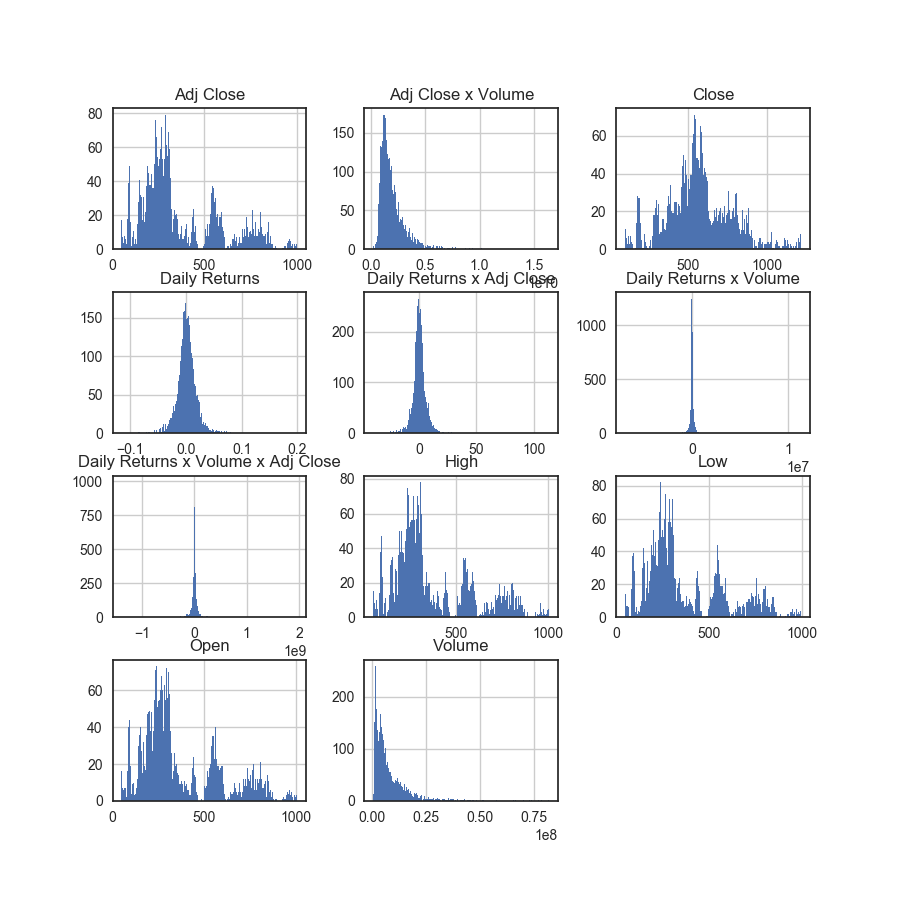

In [23]:
data_frames['GOOGL'].hist(bins=200, figsize=(9,9));

#### Scaling the Features 

In [24]:
import sklearn.preprocessing as pre

scaler = pre.StandardScaler()
# this returns a numpy array not a dataframe
G = scaler.fit_transform(data_frames['GOOGL'].dropna())

<IPython.core.display.Javascript object>


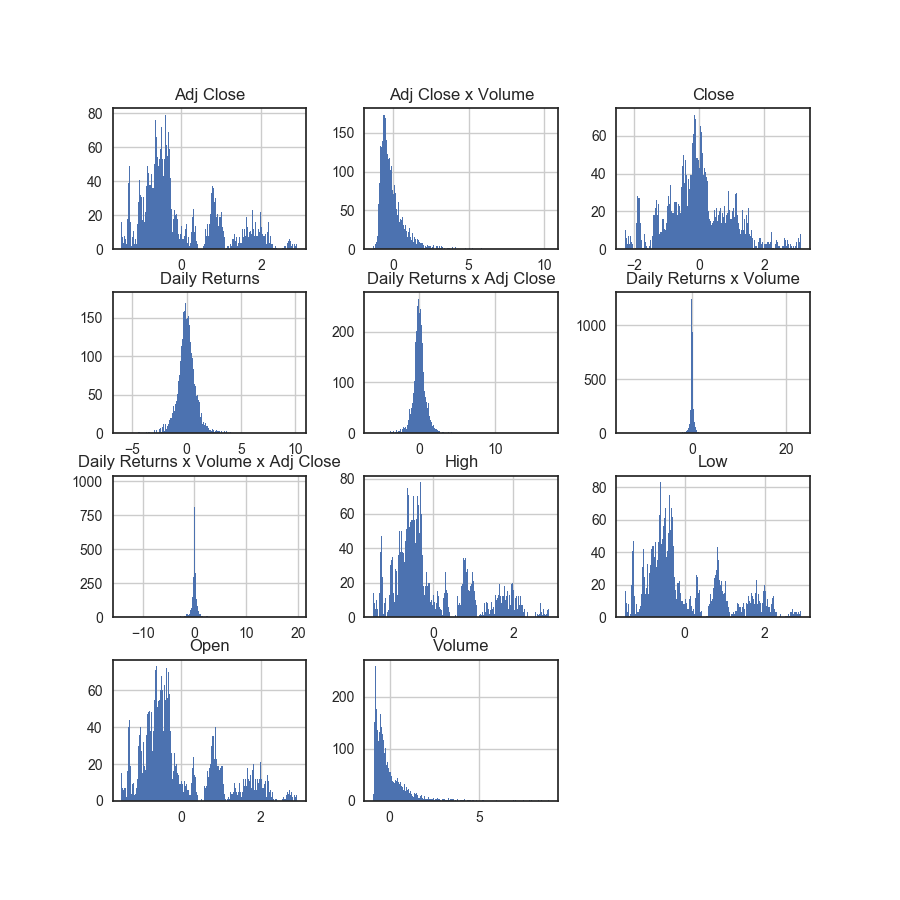

In [25]:
G = pd.DataFrame(G, index=data_frames['GOOGL'].dropna().index, columns=data_frames['GOOGL'].dropna().columns)
G.hist(bins=200, figsize=(9,9));

<IPython.core.display.Javascript object>


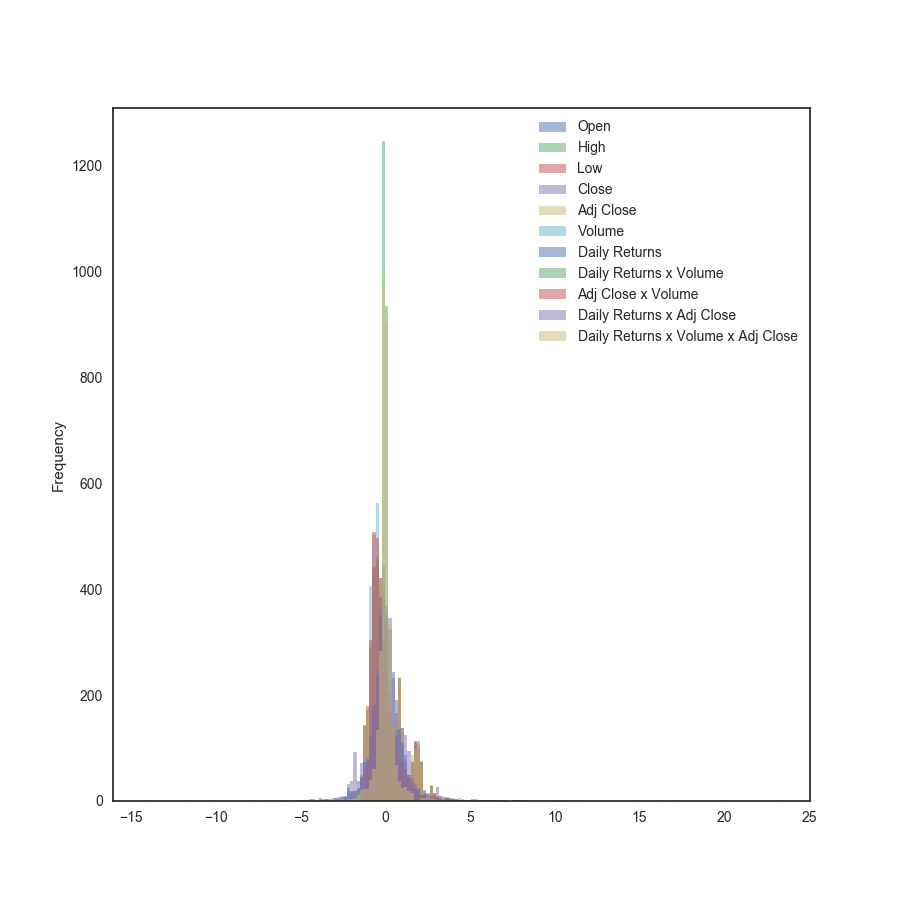

In [26]:
G.plot.hist(alpha=0.5, bins=200, figsize=(9,9));

<IPython.core.display.Javascript object>


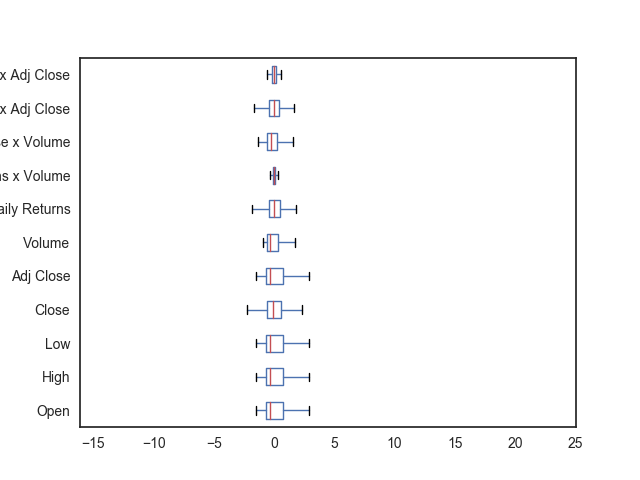

In [28]:
G.plot.box(vert=False);

<IPython.core.display.Javascript object>


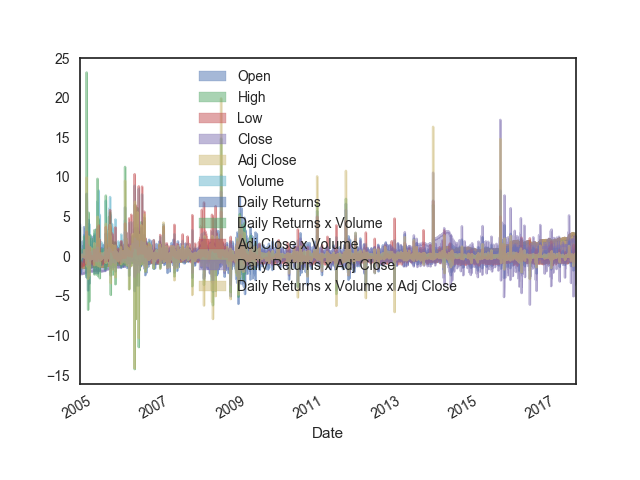

In [29]:
G.plot.area(stacked=False);

#### Scatter Matrix

Scatter matricies are another Pandas visualisation built on Matplotlib. These are really helpful in exploring both the **distribution** and **correlations** of the different features. They also show if different feature combinations may be **redundant** and unhelpful in modelling. Only half of the diagram is really needed as the plots across the diagonal with the histograms are essentially showing the same information rotated at 90 degrees counterclockwise and mirrored in a vertical plane. 

**A line plot a 45 degree diagonal indicates a correlation of 1.** Open, High, Low, Close and Adj Close were all of this general shape and hence the first four of these were removed from consideration when modelling. The diagonal can be seen in the scatter matrix which includes Open and Close for illustration. The two distinct lines for Adj Close and Close are likely because of a **7-for-1 stock split**. The similarity between the scatter plots for Open, Close, and Adj Close are clear. This is further reinforced by the **heat map** below.

<IPython.core.display.Javascript object>


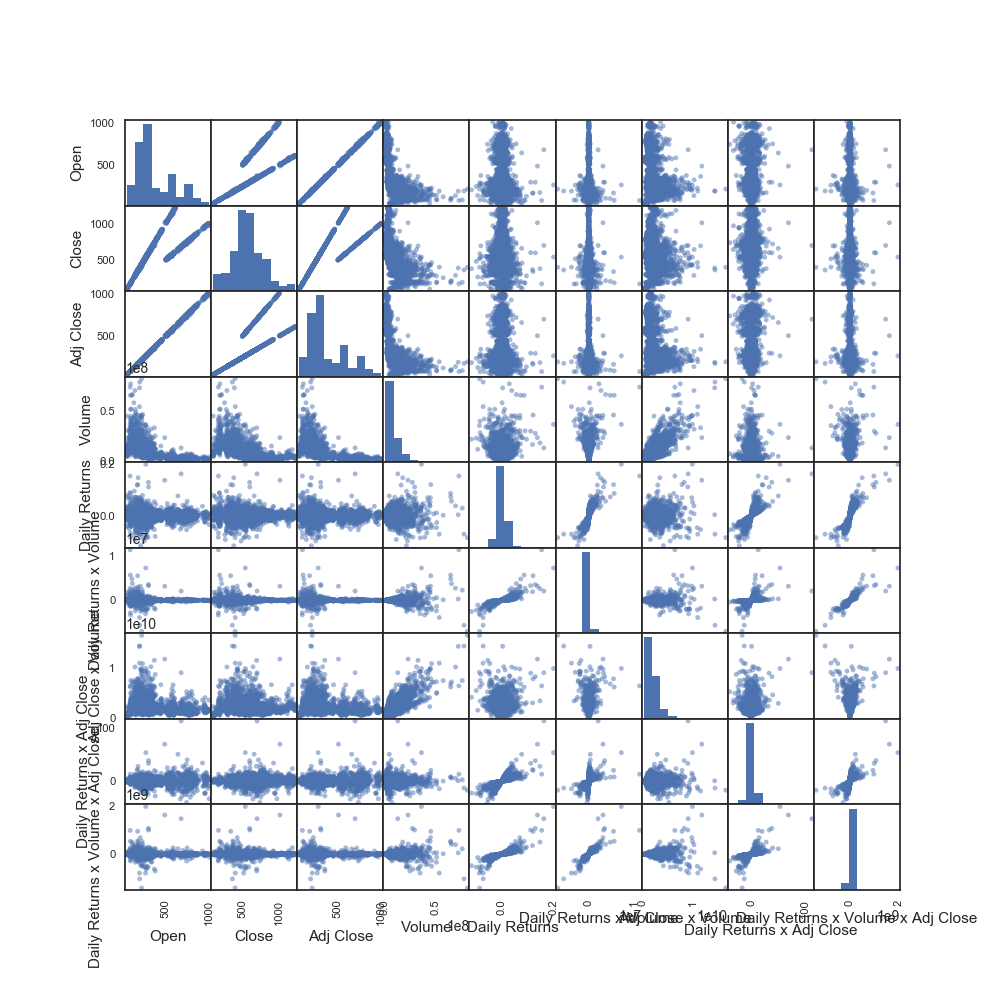

In [30]:
from pandas.plotting import scatter_matrix

attributes = ['Open','Close', 'Adj Close', 'Volume', 'Daily Returns', 
              'Daily Returns x Volume', 'Adj Close x Volume', 
              'Daily Returns x Adj Close', 'Daily Returns x Volume x Adj Close']

scatter_matrix(data_frames['GOOGL'][attributes], figsize=(10, 10));

In [31]:
GOOGL_correlations = data_frames['GOOGL'][attributes].dropna().corr()
GOOGL_correlations

,Open,Close,Adj Close,Volume,Daily Returns,Daily Returns x Volume,Adj Close x Volume,Daily Returns x Adj Close,Daily Returns x Volume x Adj Close
Open,1.000000,0.758313,0.999732,-0.557699,-0.022359,-0.037520,-0.248422,0.020421,-0.015185
Close,0.758313,1.000000,0.758648,-0.541355,-0.003785,-0.038892,-0.129481,0.041739,-0.002408
Adj Close,0.999732,0.758648,1.000000,-0.558574,-0.007387,-0.030391,-0.250185,0.037597,-0.005763
Volume,-0.557699,-0.541355,-0.558574,1.000000,0.051263,0.107552,0.804763,0.002419,0.039778
Daily Returns,-0.022359,-0.003785,-0.007387,0.051263,1.000000,0.762904,0.035869,0.839601,0.808176
Daily Returns x Volume,-0.037520,-0.038892,-0.030391,0.107552,0.762904,1.000000,0.034692,0.480096,0.882352
Adj Close x Volume,-0.248422,-0.129481,-0.250185,0.804763,0.035869,0.034692,1.000000,0.033104,0.037939
Daily Returns x Adj Close,0.020421,0.041739,0.037597,0.002419,0.839601,0.480096,0.033104,1.000000,0.685806
Daily Returns x Volume x Adj Close,-0.015185,-0.002408,-0.005763,0.039778,0.808176,0.882352,0.037939,0.685806,1.000000


<IPython.core.display.Javascript object>


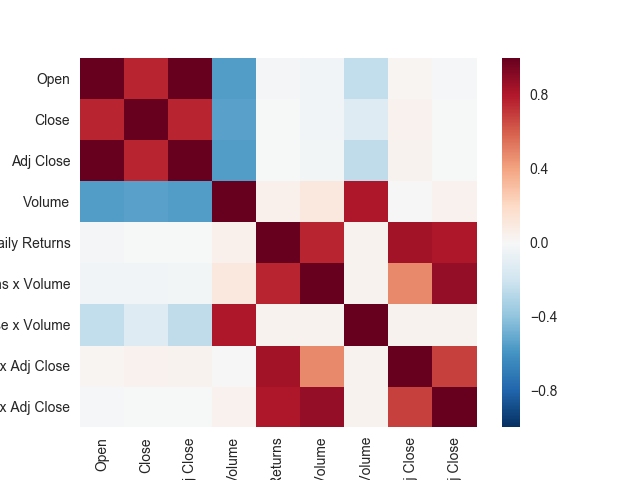

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Text yticklabel objects>)

In [32]:
plt.figure()
correlations = GOOGL_correlations
sns.heatmap(correlations, 
            xticklabels=correlations.columns.values,
            yticklabels=correlations.columns.values)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# plt.matshow(correlations)

### Plotting the generated features

<IPython.core.display.Javascript object>


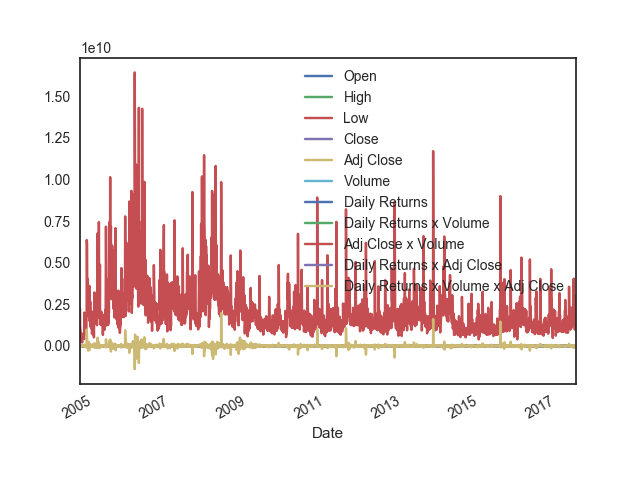

In [33]:
data_frames['GOOGL'].plot()

<IPython.core.display.Javascript object>


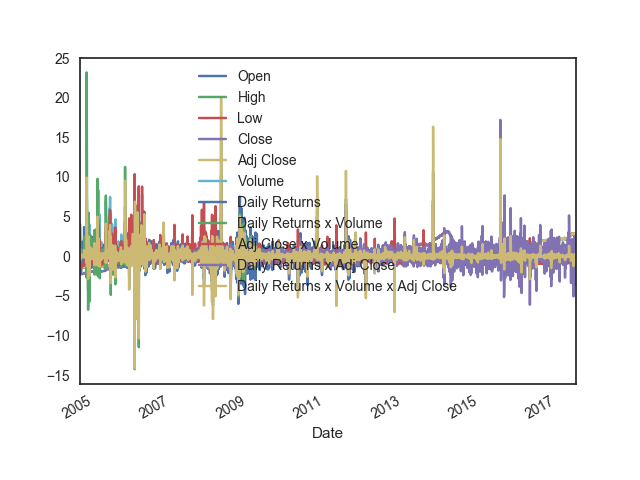

In [34]:
G.plot()

## Exploring individual features across stocks

In [9]:
# helpers
def subplot_size_and_spacing(h=9.5, w=10):
    fig = plt.figure(figsize=(h,w))
    fig.subplots_adjust(hspace=.75, wspace=.5)
    return fig
    
def add_subplots(fig, rows, subplots, i):
    if len(subplots) == 0:
        p = fig.add_subplot(rows,2,i+1)
        subplots.append(p)
    else:
        fig.add_subplot(rows,2,i+1, sharey=subplots[0], sharex=subplots[0])

def chart_labels():
    plt.xlabel('Date')
    plt.ylabel('Stock Price (US$)')

In [10]:
# create new data frame with specified features only

def create_df_from_feature(feature='Adj Close'):
    # getting the features for each item in data_frames
    ft = {}
    for ticker in stock_tickers:
        ft[ticker] = data_frames[ticker][feature]

    # class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
    df = pd.DataFrame(data = ft, index = data_frames['SPY'].index)
    return df[:'2017-07-03']

### Correlations for Daily Returns

In [37]:
# make a new data frame with daily returns.
daily_returns_df = create_df_from_feature(feature="Daily Returns")
daily_returns_df.head()

,AAPL,AMZN,FB,GOOGL,NFLX,SPY
Date,,,,,,
1993-01-29,-0.006263,NaN,NaN,NaN,NaN,NaN
1993-02-01,0.029412,NaN,NaN,NaN,NaN,0.007112
1993-02-02,-0.016326,NaN,NaN,NaN,NaN,0.002118
1993-02-03,-0.004149,NaN,NaN,NaN,NaN,0.010572
1993-02-04,-0.008334,NaN,NaN,NaN,NaN,0.004184


In [38]:
correlations = daily_returns_df.dropna().corr()
correlations

,AAPL,AMZN,FB,GOOGL,NFLX,SPY
AAPL,1.000000,0.258174,0.217539,0.324283,0.103016,0.499851
AMZN,0.258174,1.000000,0.327626,0.524947,0.315449,0.508218
FB,0.217539,0.327626,1.000000,0.340949,0.176818,0.332321
GOOGL,0.324283,0.524947,0.340949,1.000000,0.301944,0.576467
NFLX,0.103016,0.315449,0.176818,0.301944,1.000000,0.300938
SPY,0.499851,0.508218,0.332321,0.576467,0.300938,1.000000


<IPython.core.display.Javascript object>


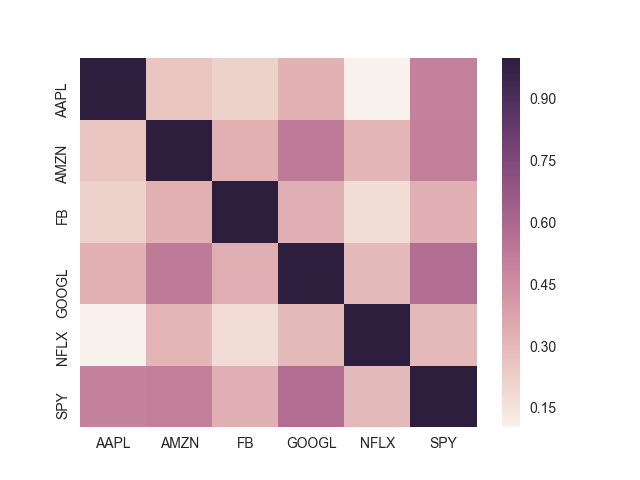

In [39]:
plt.figure()
sns.heatmap(correlations, 
            xticklabels=correlations.columns.values,
            yticklabels=correlations.columns.values)
#plt.matshow(correlations)

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, vmin=0, vmax=1)
# fig.colorbar(cax)
# ax.set_xticklabels(stock_tickers)
# ax.set_yticklabels(stock_tickers)

### Exploring the Close, Adjusted Close and Volume

In [40]:
data_frames['AAPL']['Volume'].argmax()

Timestamp('2000-09-29 00:00:00')

In [41]:
data_frames['AAPL']['Volume'].max()

1855410200

<IPython.core.display.Javascript object>


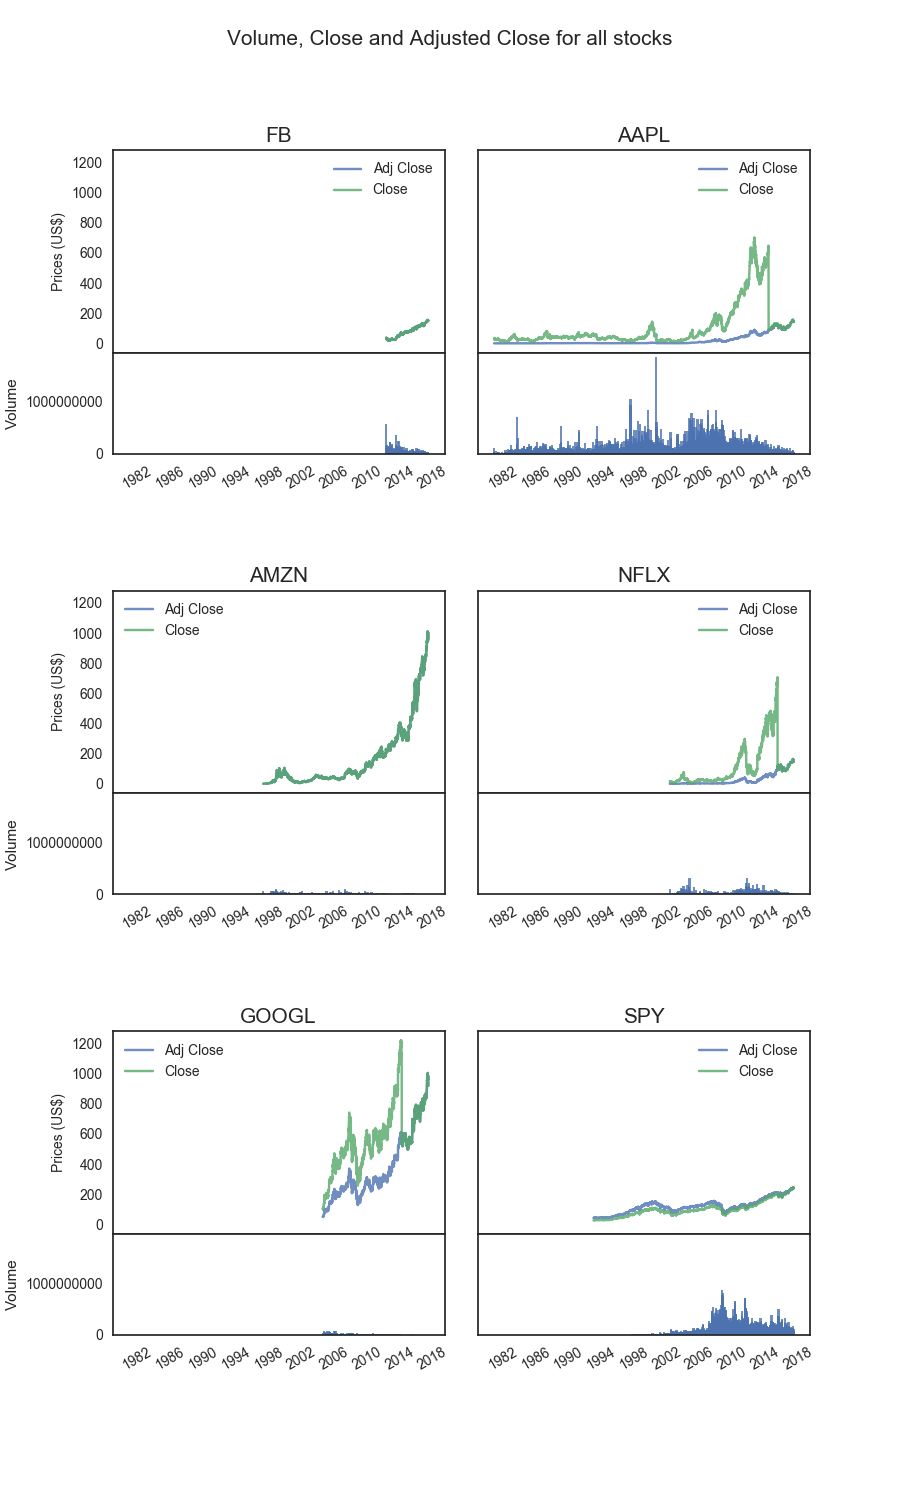

In [42]:
def plt_vol_close_adj_close():
    """ This takes a while to run. All the plots with volume in them tended to go a little slow.
    
    """
    import matplotlib
    import matplotlib.gridspec as gridspec

    def make_ticklabels_invisible(fig):
        for i, ax in enumerate(fig.axes):
            ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
            if i%2 == 0:
                for tl in ax.get_xticklabels():
                    tl.set_visible(False)

    # gridspec inside gridspec

    f = plt.figure(figsize=(9,15))

    gs0 = gridspec.GridSpec(3, 2)
    gs0.update(hspace=0.45, wspace=0.1)

    subplots = []
    ax1 = None
    ax2 = None
    
    for i, ticker in enumerate(stock_tickers):
        gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[i], hspace=0)

        # ax1 = plt.Subplot(f, gs00[:-1, :])
        
        if len(subplots) == 0:
            ax1 = plt.Subplot(f, gs00[:-1, :])
            subplots.append(ax1)
            f.add_subplot(ax1)
        else:
            ax_1 = plt.Subplot(f, gs00[:-1, :], sharey=ax1, sharex=ax1)
            f.add_subplot(ax_1)
            print

        
        plt.plot(data_frames[ticker]['Adj Close'], alpha=0.8, label = 'Adj Close')
        plt.plot(data_frames[ticker]['Close'], alpha=0.8, label='Close')
        if i%2 == 0:
            plt.ylabel('Prices (US$)', fontsize=10)
        else:
            plt.setp(ax_1.get_yticklabels(), visible=False)

            
        plt.legend(loc = "best")
        plt.title(ticker, fontsize=15)
        
        if ax2 == None:
            ax2 = plt.Subplot(f, gs00[-1, :], sharex = ax1)
            f.add_subplot(ax2)
            ax2.get_yaxis().get_major_formatter().set_scientific(False)

        else:
            ax_2 = plt.Subplot(f, gs00[-1, :], sharey = ax2, sharex = ax1)
            f.add_subplot(ax_2)
            ax_2.get_yaxis().get_major_formatter().set_scientific(False)
             
        plt.bar(data_frames[ticker].index, data_frames[ticker]['Volume'], alpha=0.8, width=100)
        if i%2 == 0:
            plt.ylabel('Volume')
        else:
            plt.setp(ax_2.get_yticklabels(), visible=False)
            
        plt.xticks(rotation=30)

    #f.tight_layout()
    # adjust space between the top title and the subplots
    f.subplots_adjust(top=0.9) 


    plt.suptitle("Volume, Close and Adjusted Close for all stocks", fontsize=15)
    make_ticklabels_invisible(plt.gcf())

    plt.show()
    
plt_vol_close_adj_close()

#### Adjusting for Stock Splits
It is evident from these charts which companies have had stock splits since trading publicly and which have not. Those very steep and sudden drops in the closing prices which meet the adjusted closing prices are instances of splits. AAPL, NFLX and GOOGL all show this phenomenon. 

For example, GOOGL had a **1998-for-1000** (averaged to **2-for-1**) stock split on April 03, 2014 as a stock dividend. Up to the date of the data being examined, this is the only split they have ever had. To adjust the price for the split all the prices prior to the split have to be divided by the split ratio, which here is 1988/1000 = 1.998. The table below confirms the split ratio by dividing the closing price by the adjusted close price.

More on the stock split here: https://www.sec.gov/Archives/edgar/data/1288776/000128877614000065/goog10-qq22014.htm.

In [43]:
splits = data_frames['GOOGL'].loc['2014-03-30':'2014-04-07'][['Close', 'Adj Close']]
splits['Split Ratio'] = splits['Close']/splits['Adj Close']
splits

,Close,Adj Close,Split Ratio
Date,,,
2014-03-31,1114.510010,557.812805,1.998
2014-04-01,1134.890015,568.013000,1.998
2014-04-02,1135.099976,568.118103,1.998
2014-04-03,571.500000,571.500000,1.000
2014-04-04,545.250000,545.250000,1.000
2014-04-07,540.630005,540.630005,1.000


FB, which has not had a stock split up to the dates considered while publicly trading, shows no similar steep drops and the close and adjusted close lines appear to completely overlap.

#### Adjusting for dividends
Reduce the stock price by the amount of the dividend on the **ex-dividend date** (when the security no longer trades with its declared dividend). These would not be such large amounts as a stock split and so would not be as obvious on the charts. As of this writing none of the FAANG stocks have had dividends except for AAPL. The price of the dividend tends to be very small and so is not as obvious as stock splits on the charts. The largest dividend so far for AAPL has been \$3.29 which occurred on 5/8/2014 (see: http://www.nasdaq.com/symbol/aapl/dividend-history). This pales in comparison to the \$566.98 difference seen in the table above for 2 April, 2014.

#### Purpose of Using the Adjusted Close
Using the adjusted close prices for predictions is important because the algorithm will mistakenly interpret the drop in prices with splits and dividends as a drop in the market value of the stocks. This can prompt the trading algorithm to act as though there is a major sell off in the stock. 

#### Note on the AMZN Data
Amazon is excluded from the discussion here because the data available on the date it was acquired was different from the data for the other stocks. The closing prices were adjusted for splits and so cannot be compared to the other stocks which were not adjusted for splits. 

<br/>
![](http://gdurl.com/6Fkk)
<center>
https://finance.yahoo.com/quote/AMZN/history?period1=916372800&period2=936417600&interval=1d&filter=history&frequency=1d</center>

<br/>
This is clear when comparing the present data (Aug 5, 2017) for GOOGL before the 2-for-1 stock split to the data in the table above with the old data and the split ratio.

![](http://gdurl.com/BUYr)

<center>
https://finance.yahoo.com/quote/GOOGL/history?period1=1395892800&period2=1407124800&interval=1d&filter=history&frequency=1d
</center>

From the footnotes on Yahoo Finance: *Close price adjusted for splits.**Adjusted close price adjusted for both dividends and splits.

#### Volume
The volume can also play a significant role in interpreting the price of the stocks. For example, looking at the corresponding volume for the day of a splt could reinforce that this is not really a sell off and just a split. however, this may not necessarily be the case, as the two events can theoretically occur simultaneously.

Comparing all the charts AAPL seems to have the highest volume traded over time. There are a few spikes in volume over time. 

### Comparing Adjusted Close Prices for all the Stocks.

#### Creating a DataFrame of Adjusted Close Prices

These were the prices that were initially fed to the estimators. In further study additional features will be tried on the models to check performance.

In [11]:
adj_close_df = create_df_from_feature() 

In [45]:
adj_close_df.tail()

,AAPL,AMZN,FB,GOOGL,NFLX,SPY
Date,,,,,,
2017-06-27,143.729996,976.780029,150.580002,948.090027,151.029999,241.330002
2017-06-28,145.830002,990.330017,153.240005,961.010010,153.410004,243.490005
2017-06-29,143.679993,975.929993,151.039993,937.820007,150.089996,241.350006
2017-06-30,144.020004,968.000000,150.979996,929.679993,149.410004,241.800003
2017-07-03,143.500000,953.659973,148.429993,919.460022,146.169998,242.210007


In [46]:
adj_close_df.describe()

,AAPL,AMZN,FB,GOOGL,NFLX,SPY
count,6152.000000,5067.000000,1289.000000,3241.000000,3805.000000,6152.000000
mean,27.756705,166.762005,77.392304,373.599816,29.283900,122.749632
std,38.841790,214.454944,38.784688,216.714955,39.518769,46.730679
min,0.417322,1.395833,17.730000,50.055054,0.372857,43.406200
25%,1.215835,35.315000,41.340000,225.795792,3.344286,93.564200
50%,4.945604,69.099998,76.839996,292.067078,7.851429,120.389999
75%,45.086547,226.389999,110.629997,540.729980,43.664288,142.803127
max,156.100006,1011.340027,155.070007,1004.280029,165.880005,244.660004


#### Line Plot for Adjusted Close

<IPython.core.display.Javascript object>


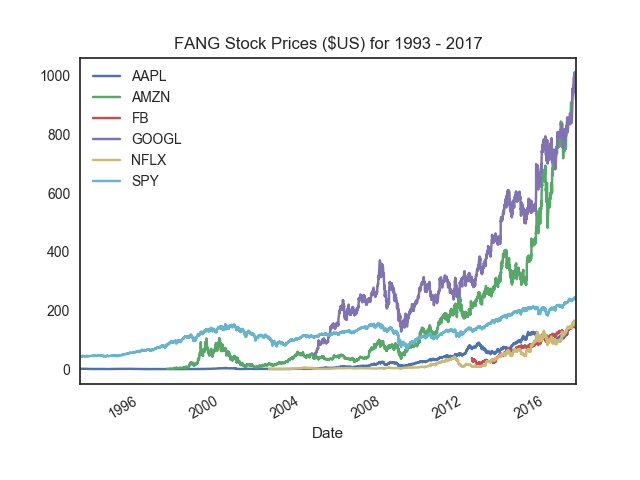

In [47]:
adj_close_df.plot()
plt.title("FAANG Stock Prices ($US) for {0} - {1}".format(adj_close_df.index[0].year, adj_close_df.index[-1].year))

In [48]:
adj_close_df.index

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
               '2017-06-30', '2017-07-03'],
              dtype='datetime64[ns]', name='Date', length=6152, freq=None)

#### Statistics with Box Plot for Adjusted Close

AAPL has a very low mean because the stock price was low for many years after the company went public before it skyrocketed.

<IPython.core.display.Javascript object>


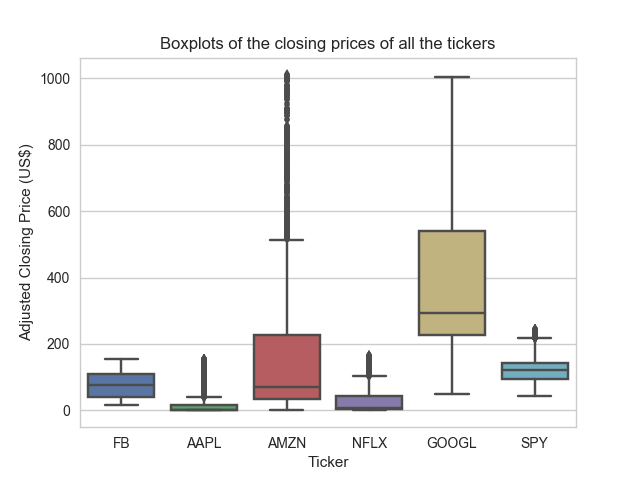

In [49]:
# boxplots for all the different stocks
# do this for the adj closes instead
# those black points are outliers

def box_plots_all():
    sns.set_style("whitegrid")
    plt.figure()

    adj_closes = []
    
    for ticker in stock_tickers:
        adj_closes.append(data_frames[ticker]['Adj Close'])
    
    #plt.boxplot(adj_closes) #, whis = 'range'
    sns.boxplot(data=adj_closes);
    
    arr = np.arange(0, len(stock_tickers))
    
    # these need to go under the plt.boxplot
    plt.xticks(arr, stock_tickers)
    plt.title("Boxplots of the closing prices of all the tickers")
    plt.xlabel('Ticker')
    plt.ylabel('Adjusted Closing Price (US$)')
    
box_plots_all()

## Conversion of DateTimeIndex to Number of Days Elapsed (int)

The time elapsed since the start of trading a particular stock was 

In [50]:
adj_close_df.tail()

,AAPL,AMZN,FB,GOOGL,NFLX,SPY
Date,,,,,,
2017-06-27,143.729996,976.780029,150.580002,948.090027,151.029999,241.330002
2017-06-28,145.830002,990.330017,153.240005,961.010010,153.410004,243.490005
2017-06-29,143.679993,975.929993,151.039993,937.820007,150.089996,241.350006
2017-06-30,144.020004,968.000000,150.979996,929.679993,149.410004,241.800003
2017-07-03,143.500000,953.659973,148.429993,919.460022,146.169998,242.210007


In [12]:
from datetime import timedelta, datetime, date

def convert_date_to_time_elapsed(df):
    dates = df.index

    elapsed = dates - dates[0]
    # type(elapsed.days.map(str))
    df['Days Elapsed'] = elapsed.days
    df = df.set_index(['Days Elapsed'], inplace=True, append="True")

convert_date_to_time_elapsed(adj_close_df)

In [16]:
adj_close_df.head()

,,AAPL,AMZN,FB,GOOGL,NFLX,SPY
Date,Days Elapsed,,,,,,
1993-01-29,0,1.848381,NaN,NaN,NaN,NaN,43.9375
1993-02-01,3,1.902745,NaN,NaN,NaN,NaN,44.2500
1993-02-02,4,1.871680,NaN,NaN,NaN,NaN,44.3437
1993-02-03,5,1.863914,NaN,NaN,NaN,NaN,44.8125
1993-02-04,6,1.848381,NaN,NaN,NaN,NaN,45.0000


In [53]:
# DataFrame.xs(key, axis=0, level=None, drop_level=True)
# this does not work elementwise so converting the date with a calculation instead.
adj_close_df.xs(4, level=1).index

DatetimeIndex(['1993-02-02'], dtype='datetime64[ns]', name='Date', freq=None)

In [13]:
X_train = np.array([2,3,4]).reshape(-1,1)

def convert_time_elapsed_to_date(days_elapsed, df):
    days_elapsed = days_elapsed.reshape(1, -1)[0]
    days_elapsed = pd.to_timedelta(days_elapsed, unit='d')
    # date = original day + time elapsed
    return df.index.levels[0][0] + days_elapsed

convert_time_elapsed_to_date(X_train, adj_close_df)

DatetimeIndex(['1993-01-31', '1993-02-01', '1993-02-02'], dtype='datetime64[ns]', freq=None)

## Handling Missing Data

**Backfilling** the missing data was tried to prepare the data for estimators and plotting. However, the significant expanse of the data that was filled in meant that certain algorithms took a severe performance hit.

For instance FB had to be filled in from 1993 to 2012 when it had its IPO. Thats longer than it has actually been trading for. For smaller periods this may be more appropriate. This technique was thus replaced with dropping the rows with the missing data instead. The remaining rows were then fed to the estimators and led to much better performance.

### Backfilling Missing Data

In [55]:
adj_close_df.head()

,,AAPL,AMZN,FB,GOOGL,NFLX,SPY
Date,Days Elapsed,,,,,,
1993-01-29,0,1.848381,NaN,NaN,NaN,NaN,43.9375
1993-02-01,3,1.902745,NaN,NaN,NaN,NaN,44.2500
1993-02-02,4,1.871680,NaN,NaN,NaN,NaN,44.3437
1993-02-03,5,1.863914,NaN,NaN,NaN,NaN,44.8125
1993-02-04,6,1.848381,NaN,NaN,NaN,NaN,45.0000


In [56]:
def backfill(df):
    # use inplace=True to modify the original df
    df.fillna(method="backfill")
    
backfill(adj_close_df)

<IPython.core.display.Javascript object>


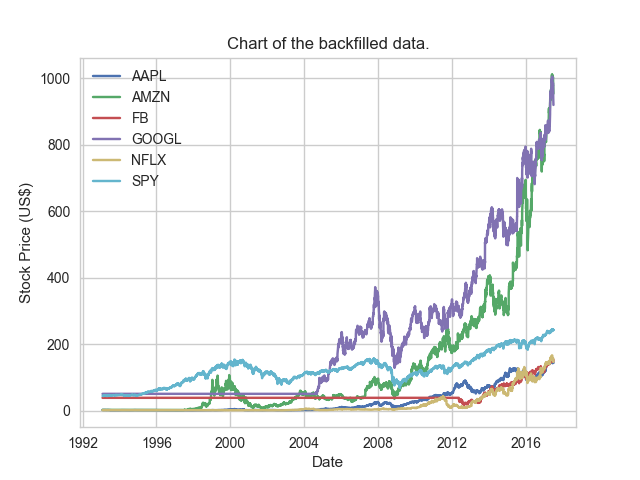

In [57]:
def plot_backfilled_data():
    plt.figure()
    for ticker in adj_close_df.columns.values:
        plt.plot(adj_close_df.index.levels[0], adj_close_df[ticker].fillna(method="backfill"), label=ticker)
    plt.legend()
    plt.title("Chart of the backfilled data.")
    chart_labels()

plot_backfilled_data()

### Removing NANs

In [ ]:
def clean_nans(ticker):
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)

## Scaling the data

In [ ]:
def scale_X(X):    
    scaler = preprocessing.StandardScaler()
    X = scaler.fittransform(X)

# 4.0 Modelling

## Methodology

### Overview and Introduction to Machine Learning Concepts and Techniques
The general strategy used to determine the best model involves selecting several models, then training them and comparing the results using some metric. The specifics vary depending on the model itself and the particulars involved. These will be described in more detail in the sections that follow.

#### Supervised and Unsupervised learning
In supervised learning, features and outputs/labels in the training data are known at the start and these are used to train the model. (In contrast, with unsupervised learning, there are no labels to learn from. This is used with such techniques as clustering to discover similarities between data points.). This is the type of learning used here. 

#### The objective function
The objective function (also called the  **cost** or **loss** function) is used to choose the best parameters $\theta_0 ... \theta_n$ for the hypothesis function such that the error of the difference between the actual label values and the prediction values produced by using particular parameters is minimised. **Techniques used to minimise objective functions include stochastic gradient descent, mini-batch gradient descent, adagrad etc.**

After the model is trained, its generalisation to unseen data is measured with the test set. Metrics **like precision, recall, accuracy** can be used to measure its performance **against some benchmark??**. Finally the model can be used for predicting on new real-world data. 

### Modelling with Scikit-Learn
Most of the models in Scikit-Learn come with both Regression and Classification counterparts. Thus, you have Random Forest Regressors and Random Forest Classifiers. Similarly there are Support Vector Regressors and Support Vector Classifiers.

Modelling in Scikit-Learn follows a series of 4 basic steps no matter which model is used. They are: 
1. Import the model
2. Instantiate the model
3. Fit the model
4. Perform predictions

Much additional complexity can be added to this basic framework as Scikit-Learn comes with a variety of tools to facilitate the full machine learning pipeline. Modules exist for creating train/test splits, performing cross-validation in multiple ways, persisting models and adding pipelines. 

**Train/Test Split**

Training on all the data leads to **overfitting** and **over-optimistic scoring**. Train/test splits are an improvement over the prior method. The data is split into about 60% for training and 40% for testing and the model is trained only on the training set. Then, it is tested using unseen data from the test set. The problem with this approach is that it produces different metrics depending on the samples that are randomly drawn for training. 

** Cross Validation**<br/>

Cross validation ammends this problem by taking the average of the metrics from different train/test splits. It can thus produce more reliable results on predictions. Cross validation splits the data set into **folds** and uses each fold as the test set and the other sets as the training set for the number of folds in the data set. 

So, if there are 10 folds, the data will be split into 10 folds where the first 9 are for training and the last 1 is for testing. Then on the second pass, the second to last fold will be used for testing and the rest for training. This process is repeated until all 10 folds are used for testing. To choose the best performing model do cross validation on each model and choose the one that performs the best.

**GridSearchCV and RandomGridSearchCV**<br/>

To take it up a notch, grid search cross validation and randomised grid search cross validation can be used. These are both great for fine tuning parameters because they automatically sort through different parameters and prevent the need to do this manually. Then they return the best performing model which can be used for training and predictions! 

Grid search CV takes a finite set of specific parameters to search over. Randomised grid search CV can sort through a range of parameters from which it randomly chooses and then returns the best model. It is better for use when there is a wider range of parameters to search over which would be impractical to do exhaustively with grid search CV. 

Research has shown that where the choice exists, **Random Grid Searches provide better results in less passes than Grid Search**.

One caveat is that these can both be a bit slow depending on how many cross-validation folds there are and how many parameters are being searched over. Higher numbers for both mean a longer search time.

**Model Persistence**<br/>

Additionally, Scikit-Learn has built in support for **pickling** and model persistence. This is very useful when a model takes a long time to train. Persistence can be used to save the trained model. It can then be reloaded and predictions can be done directly on that trained model.

**Pipelines**<br/>

These are great for preprocessing steps like feature scaling and feature selection. When used with Grid searched the parameters for these can also be searched through.

## Predicting Stock Prices using Regression

### Linear Regression Overview

Linear Regression is one of the more fundamental learning algorithms. It is a type of supervised learning where one works backward from the data to find a line of best fit through that data. It only works well where the data has a linear shape. It does however, scale well to out of sample data beyond the test set and so in certain cases may be a good choice.

In the most simplified form **univariate linear regression**, there is only one feature or variable used to train the model. This is similar to having a feature only aligned to the x-axis with the output vector on the y-axis. This model has a parallel to the equation of a line where $y$ is the value output when the gradient is $m$, the $x$ value $x$ and the y-intercept is $c$. The hypothesis or predicted value $ h_\theta(x) $ corresponds to $y$, the learned parameters $ \theta_0 $ and $ \theta_1 $ correspond to $c$ and $m$ respectively, and the feature $ x_1 $ correponds to $ x $. Models predicting the adjusted close prices of the stocks presented above are shown in the next subsection. 

$$ y = c + mx $$
$$ h_\theta(x) = \theta_0 + \theta_1x_1 $$


**Multivariate linear regression** occurs when there are multiple features used to train the model. The number of features typically can be quite large. In this case, the output vector would again be what is to be predicted ie. the adjusted stock price. The training time will likely increase proportionately with the number of features used. When there are more than two features plotting the features to understand the data becomes problematic. Principal component analysis can be used to to decompose the model so that it can be plotted in 3D. The prediction function will now be a hyperplane rather than a line through the data. The equation of the line expands to accommodate the number of features $n$. 

$$ h_\theta(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n$$

The most popular metric for performance evaluation is the **mean squared error** which is used by default by scikit-Learn. There are no parameters to be tuned with the most basic model so GridSearchCV will not be necessary. <span style="color:hotpink">__Parameter scaling__</span>, cross-validation, regularisation (ridge) and feature tuning will be attempted to see if model performance improves.

### Linear Regression with a train/test split

In [18]:
# lin reg results collection
# create a dictionary for each 
lin_reg_res_dict = {}

In [19]:
def lin_reg(df, ticker, i):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
         
    # X = df[ticker].dropna().index.levels[1].values.reshape(-1, 1)
    y = df[ticker].dropna()
    # cut it from the end to be the same length
    # print(len(y))
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    #print(X)
    #print(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
    
    linreg = LinearRegression()

    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    mse = metrics.mean_squared_error(y_test,y_pred)

    # results collection
    # the score shows the proportion of the items that were correctly identified (in classification) 
    # in the training or test set.
    lin_reg_res_dict[ticker] = [mse, np.sqrt(mse), linreg.score(X_train, y_train), linreg.score(X_test, y_test)]
    
    #print(ticker)
    #print("MSE: {}".format(mse))
    #print("RMSE: {}".format(np.sqrt(mse)))
   
    # this might be the accuracy?
    #print("Training: {}".format(linreg.score(X_train, y_train)))
    #print("Testing: {}".format(linreg.score(X_test, y_test)))
    
    # plotting the function
    plot_lin_reg(df, linreg, X_train, X_test, y_train, y_test, i, ticker)

In [20]:
# adjust height depending on num rows 3.33 per row

def plot_lin_reg(df, linreg, X_train, X_test, y_train, y_test, i, ticker):

    add_subplots(fig, rows, subplots, i)

    y_linreg = X_train*linreg.coef_ + linreg.intercept_ 
    y_pred = linreg.predict(X_test)

    X_train_plot = convert_time_elapsed_to_date(X_train, df)
    X_test_plot = convert_time_elapsed_to_date(X_test, df)

    plt.scatter(X_train_plot, y_train, label=ticker, marker= 'o', s=1, alpha=0.7, color='#B2F042')
    plt.scatter(X_test_plot[:50], y_pred[:50], label='Selected Predictions from the test set', 
                marker= 'x', s=1, alpha=0.75, color='b')

    plt.plot(X_train_plot, y_linreg, label='Hypothesis function', color="#C70039", linewidth=1, alpha=0.6)

    chart_labels()
    plt.title('Predictions for {}'.format(ticker))
    #plt.legend(loc="best")
    

    plt.show()

<IPython.core.display.Javascript object>


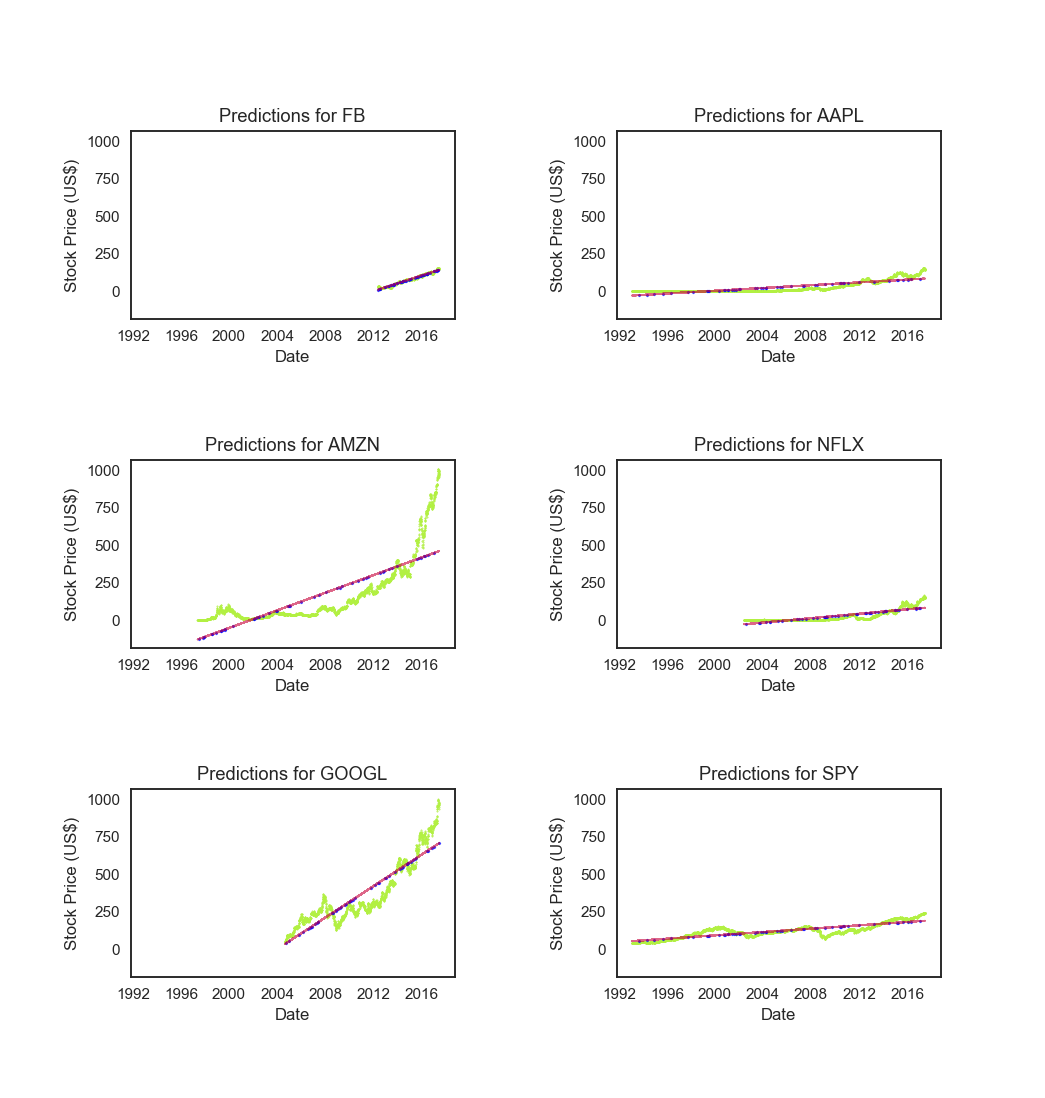

In [23]:
rows = math.ceil(len(stock_tickers)/2)
fig = subplot_size_and_spacing(9.5, 3.33*rows)
subplots = []
    
def lin_reg_start():
    for i,ticker in enumerate(stock_tickers):
        lin_reg(adj_close_df, ticker, i)

lin_reg_start()

In [99]:
def show_lin_reg_results_table():
    lin_reg_res = pd.DataFrame(data=lin_reg_res_dict, 
                               index=['MSE', 'RMSE', 'Train Score', 'Test Score'], 
                               columns=stock_tickers)
    return lin_reg_res

show_lin_reg_results_table()

,FB,AAPL,AMZN,NFLX,GOOGL,SPY
MSE,44.370754,442.902287,16430.991559,536.522275,8453.778730,667.555644
RMSE,6.661138,21.045244,128.183429,23.162950,91.944433,25.837098
Train Score,0.970613,0.702027,0.625136,0.657785,0.818791,0.703205
Test Score,0.969478,0.687422,0.635250,0.680275,0.834853,0.677467


**Interpretation of the charts and results**

As predicted the stocks with more linear shapes were better fit by the models. FB has an almost perfect fit with very little error and the highest test score out of all the stocks. AMZN on the other hand which has a more polynomial shape performed the worst of all the models.

Logically also, performance is better where there is less volatility as this means there is less error and deviation from the model. Though GOOGL has a linear trend, FB showed much better results because it is much less volatile.

### Linear Regression with Cross Validation

#### Set up for results collection

In [14]:
# this collects the scores for all the following regression models so they can be compared.
best_scores_dict = {}

def regression_score_collector():
    """ Initiaites a dictionary so that the scores can be collected for comparison with the other models 
        in the results section.
    """
    # initiate this for all tickers and all the models
    # Are these being used?
    scores_init = {'Linear': np.random.rand(),
                   'Polynomial Reg': np.random.rand(),
                   'KNN':np.random.rand(), 
                   'SVM':np.random.rand(), 
                   'Neural Net':np.random.rand(), 
                   'Random Forest': np.random.rand()}

    for ticker in stock_tickers:
        best_scores_dict[ticker] = {   'Linear': None,
                                       'Polynomial Reg': None,
                                       'KNN':None, 
                                       'SVM':None, 
                                       'Neural Net':None, 
                                       'Random Forest': None   } 
        
regression_score_collector()
#best_scores_dict

In [37]:
models = ['Linear', 'Polynomial Reg', 'KNN', 'SVM', 'Neural Net', 'Random Forest']
# class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
# get double level columns?

results = pd.DataFrame(data = best_scores_dict, index=models, columns=stock_tickers)
results

,FB,AAPL,AMZN,NFLX,GOOGL,SPY
Linear,56.385561,779.946179,32042.703004,866.831298,12790.029940,959.436169
Polynomial Reg,26.649302,52.814319,926.417195,77.242020,1442.653434,263.824906
KNN,97.597349,124.675871,10954.744196,122.574852,3997.890702,216.903263
SVM,2098.055520,2205.789837,61357.285216,2210.624242,63003.979934,2666.090352
Neural Net,1604.577348,1424.914026,41911.659903,1416.341956,29549.700464,1086.352893
Random Forest,99.817906,127.020996,11171.586235,126.453206,3980.275900,215.764202


<br/>

In [16]:
def lin_reg_cv(df, ticker):
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    linreg = LinearRegression()
    y_pred = cross_val_predict(linreg, X, y, cv=10)
    scores = cross_val_score(linreg, X, y, scoring="neg_mean_squared_error", cv=10)
        
    print("{} All Scores: {}".format(ticker,-scores))
    print("{} MSE: {}".format(ticker,-scores.mean()))
    print("")

    best_scores_dict[ticker]['Linear'] = -scores.mean()
    #print(best_scores_dict)
    #print(scores.std())
    
    #print(np.sqrt(scores))
    #print(np.sqrt(-scores.mean()))
    #print(np.sqrt(scores.std()))

for ticker in stock_tickers:    
    lin_reg_cv(adj_close_df, ticker)

FB All Scores: [ 170.86832013   46.38107351   91.14405701   40.30552754   17.36134291
   37.4573437    24.00154042   20.59290181   40.95468132   74.78881771]
FB MSE: 56.38556060544861

AAPL All Scores: [ 1354.71984156   287.1575885     12.32783753   127.04274007   505.13930913
   691.11713645   851.99202529   207.14950634   341.15901544  3421.6567934 ]
AAPL MSE: 779.9461793706176

AMZN All Scores: [  3.35956391e+04   1.49148162e+04   1.66461101e+02   2.13175940e+03
   1.20181091e+04   1.94546548e+04   1.80028795e+04   1.11821957e+04
   2.88268116e+03   2.06077834e+05]
AMZN MSE: 32042.703003995477

NFLX All Scores: [ 1177.39399523   307.29597539    16.1154947    116.14219772   424.99640471
   267.17632717  1334.79601761   476.38191336   756.14395164  3791.87070709]
NFLX MSE: 866.8312984619339

GOOGL All Scores: [  5934.54681317  10450.0239993    8779.08417348   8061.36810963
   6432.00358985  17643.7746179   15002.10866634   1551.95897057
   6425.23421691  47620.19624019]
GOOGL MSE: 127

**Interpretation of the Results**

The MSEs are all higher than before. This may seem surprising at first. If using cross validation is meant to be the better technique then why is it giving the worse results? CV is taking the average of all the scores. Looking at all the scores reveals that the range of errors is quite wide. Thus the prior results probably produced the lower scores from the set of possible scores. Hence, in the wild using cross validation is the more reliable and robust way to perform modelling.

### Ridge Regression

Ridge regression adds regularisation to the mix.
The model can be tuned for this parameter. Varying alpha in this case did not produce any noticeable difference.

In [ ]:
def ridge_regression(df, ticker, alpha):
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import train_test_split

    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    
    linridge = Ridge(alpha=alpha).fit(X_train, y_train)
    
    print(ticker)
    #print(linridge.intercept_)
    #print(linridge.coef_)
    print("Training score {}".format(linridge.score(X_train, y_train)))
    print("Testing score {}".format(linridge.score(X_test, y_test)))
    
def plot_ridge_regression():
    pass

for ticker in stock_tickers:
    for alpha in [1, 10, 15, 20]:
        ridge_regression(adj_close_df, ticker, alpha)

### Polynomial Regression

This makes a significant difference and should be considered.

In [18]:
# Grid Search CV can be used here because there is a parameter to train for 
# with the number of polynomial degrees and the alpha value in ridge regression. 
# I think - I have to check. Might just have to use a for loop instead.
# Regularisation should be applied because adding the polynomials can lead to overfitting.

def poly_reg(df, ticker, deg):

    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn import metrics
    
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)

    poly = PolynomialFeatures(degree=deg)
    X_F1_poly = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                       random_state = 0)
    # best_scores_dict[ticker]['SVM'] = -rand.best_score_

    linreg = Ridge().fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    mse = metrics.mean_squared_error(y_test,y_pred)

    #print(linreg.coef_)
    #print(linreg.intercept_)
    print(ticker)
    # print("Alpha: {}".format(alpha))
    print("Poly: {}".format(deg))
    print("Training Score: {}".format(linreg.score(X_train, y_train)))
    print("Testing Score: {}".format(linreg.score(X_test, y_test)))
    print("MSE: {}".format(mse))
    print("RMSE: {}".format(np.sqrt(mse)))

    print("")
    
    if deg == 6:
        best_scores_dict[ticker]['Polynomial Reg'] = mse

# poly_reg(adj_close_df, 'GOOGL')

# varying alpha does not seem to have much effect on the results
# so this approach was discarded.
# varying alpha with the deg may be more effective.
for ticker in stock_tickers: 
    for deg in [2, 4, 6]:
        poly_reg(adj_close_df, ticker, deg)

FB
Poly: 2
Training Score: 0.9732465837813223
Testing Score: 0.9735548799053794
MSE: 38.44429262267622
RMSE: 6.2003461695841

FB
Poly: 4
Training Score: 0.9777604051933019
Testing Score: 0.9776912311495891
MSE: 32.43111903701675
RMSE: 5.694832661019703

FB
Poly: 6
Training Score: 0.981453702611322
Testing Score: 0.9816684366378755
MSE: 26.649301784339375
RMSE: 5.162296173636241

AAPL
Poly: 2
Training Score: 0.94776662027256
Testing Score: 0.942766468543639
MSE: 81.09619424541793
RMSE: 9.005342539038587

AAPL
Poly: 4
Training Score: 0.9649359516606625
Testing Score: 0.96101815694753
MSE: 55.234738024821944
RMSE: 7.432007671203115

AAPL
Poly: 6
Training Score: 0.9664762483447908
Testing Score: 0.9627263646275023
MSE: 52.81431876531537
RMSE: 7.267346060654837

AMZN
Poly: 2
Training Score: 0.8991192344767954
Testing Score: 0.9035162024619465
MSE: 4346.329488842596
RMSE: 65.92669784573316

AMZN
Poly: 4
Training Score: 0.9708376580607858
Testing Score: 0.9706051854647278
MSE: 1324.1554799221

**Interpreting the Results**

Even without using cross validation the results here are a great improvement over linear regression. This is especially true for the stocks where the shape of the data is more quadratic in shape like AMZN. Increasing the number of polynomial features seems to improve performance without overfitting as both the training and testing scores go up. 

### K Nearest Neighbour Regression

K nearest neighbour (KNN) is one of the more straight-forward learning algorithms to understand. It is instance based which means that the model memorises the the training points then references those when making predictions. To make a prediction, the model looks at the number of nearest neighbours specified as a hyperparameter in the model, that is the value of K. Lower values of K are prone to overfitting and too much complexity, while larger values are prone to higher bias and too much simplicity.  Thus, values in between the two extremes are likely to perform the best. So if $K=3$, and there is a new point $x_1$, take the 3 nearest points on the x-axis then get the average distance between the three to predict the output. These distances can be uniform or weighted. When weighted, the points which are closer have more effect on the prediction. The metric use is a version of the Minkowski distance which is essentially the equivalent of the Euclidian distance.

KNN is not as good as linear regression at scaling to out of sample data, since the model does not make many assumptions about the data. Also many sparse features slow down the algorithm so it may not be a good choice for text data.

In [140]:
def knn_regressor(df, ticker):
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors = 50, weights="uniform")
    
    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    #----repeated---
    
    knn.fit(X_train, y_train)
    
    #----repeated---
    print("Training score {}".format(knn.score(X_train, y_train)))
    print("Testing score {}".format(knn.score(X_test, y_test)))
    #----repeated---

for ticker in stock_tickers:  
    print(ticker)
    knn_regressor(adj_close_df, ticker)

FB
Training score 0.9937605680903716
Testing score 0.9933200198969143
AAPL
Training score 0.9980332599751163
Testing score 0.9981006212558943
AMZN
Training score 0.9973038135996423
Testing score 0.997092397837628
NFLX
Training score 0.9942192546722832
Testing score 0.9940955620492191
GOOGL
Training score 0.9945945476561644
Testing score 0.9952120717295193
SPY
Training score 0.9961871434280306
Testing score 0.9959029826405468


#### Cross Validation 

In [141]:
def knn_regressor_cv(df, ticker):

    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.model_selection import cross_val_score
    knn = KNeighborsRegressor(n_neighbors = 10, weights="uniform")
    
    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    # cv indicates the # of folds to use. This is 10 fold cross validation
    scores = cross_val_score(knn, X,y, cv=10, scoring='neg_mean_squared_error')
    #print(-scores)
    print(-scores.mean())

#   X_train, X_test, y_train, y_test = train_test_split(X,y)
#   #----repeated---
    
#   knn.fit(X_train, y_train)
    
#   #----repeated---
#   print("Training score {}".format(knn.score(X_train, y_train)))
#   print("Testing score {}".format(knn.score(X_test, y_test)))
#   #----repeated---

for ticker in stock_tickers:  
    print(ticker)
    knn_regressor_cv(adj_close_df, ticker)

FB
100.6526479
AAPL
147.365870474
AMZN
11119.2567523
NFLX
129.055535373
GOOGL
4307.22544359
SPY
227.409248677


#### GridSearchCV 

In [142]:
def knn_regressor_gridsearchcv(df, ticker):
    
    from sklearn.model_selection import GridSearchCV
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors = 10, weights="uniform")
    
    # define a set of parameters to run on a model
    param_grid = dict(n_neighbors = range(5,15), weights=["distance", "uniform"])
    #param_grid = dict(n_neighbors = range(1,15))
    
    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid.fit(X,y)
    print(grid.cv_results_)
    print("-----------------")

    print(grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)

    #print(grid.cv_results_) #cv_results_

        
#     X_train, X_test, y_train, y_test = train_test_split(X,y)
#     #----repeated---
    
#     knn.fit(X_train, y_train)
    
#     #----repeated---
#     print("Training score {}".format(knn.score(X_train, y_train)))
#     print("Testing score {}".format(knn.score(X_test, y_test)))
#     #----repeated---

knn_regressor_gridsearchcv(adj_close_df, 'AAPL')
# for ticker in stock_tickers:  
#     print(ticker)
#     knn_regressor_gridsearchcv(adj_close_df, ticker)

[mean: -138.23118, std: 191.85374, params: {'n_neighbors': 5, 'weights': 'distance'}, mean: -138.35761, std: 192.02085, params: {'n_neighbors': 5, 'weights': 'uniform'}, mean: -141.94500, std: 197.31465, params: {'n_neighbors': 6, 'weights': 'distance'}, mean: -142.14291, std: 197.58708, params: {'n_neighbors': 6, 'weights': 'uniform'}, mean: -143.30659, std: 199.60701, params: {'n_neighbors': 7, 'weights': 'distance'}, mean: -143.51654, std: 199.90490, params: {'n_neighbors': 7, 'weights': 'uniform'}, mean: -144.94699, std: 202.17682, params: {'n_neighbors': 8, 'weights': 'distance'}, mean: -145.18113, std: 202.51637, params: {'n_neighbors': 8, 'weights': 'uniform'}, mean: -146.81819, std: 205.08934, params: {'n_neighbors': 9, 'weights': 'distance'}, mean: -147.08484, std: 205.47727, params: {'n_neighbors': 9, 'weights': 'uniform'}, mean: -147.06119, std: 205.48816, params: {'n_neighbors': 10, 'weights': 'distance'}, mean: -147.31802, std: 205.86723, params: {'n_neighbors': 10, 'weigh

/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### RandomGridSearchCV 

In [21]:
def knn_regressor_randomsearchcv(df, ticker):
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors = 10, weights="uniform")
    
    # define a set of parameters to run on a model
    param_dist = dict(n_neighbors = range(1,30), weights=["distance", "uniform"])
    
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=20, random_state=0)
    rand.fit(X, y)
    rand.cv_results_
    
    print("-----------------")

    print(rand.best_score_)
    print(rand.best_params_)
    print(rand.best_estimator_) 
    
    best_scores_dict[ticker]['KNN'] = -rand.best_score_


In [22]:
%time knn_regressor_randomsearchcv(adj_close_df, 'AAPL')

-----------------
-124.675870806
{'weights': 'distance', 'n_neighbors': 2}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')
CPU times: user 21.2 s, sys: 320 ms, total: 21.5 s
Wall time: 21.8 s


In [23]:
%time [knn_regressor_randomsearchcv(adj_close_df, ticker) for ticker in stock_tickers]

-----------------
-97.5973492682
{'weights': 'distance', 'n_neighbors': 25}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=25, p=2,
          weights='distance')
-----------------
-124.675870806
{'weights': 'distance', 'n_neighbors': 2}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')
-----------------
-10954.7441962
{'weights': 'uniform', 'n_neighbors': 6}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')
-----------------
-122.574852328
{'weights': 'distance', 'n_neighbors': 25}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=25, p=2,
          weights='distance')
-----------------
-3997.89070204
{'weights': 'dist

[None, None, None, None, None, None]

### Support Vector Machines

- SVMs are particularly well suited for classification of complex but small- or medium-sized datasets. (Geron)
thus it may perform well in this instance.
- You want the largest margin because the model may not generalise well to new data if the boundaries 
are too close to the clusters. This is large margin classification.
- The decision boundary is determined by the points (supports) at the edge of the clusters and are nto affected 
by any of the other points further away.
- They are sensitive to feature scaling. the scaled data tends to perform better.
- The outputs are not probabilities like with logistic regression.
- hard margin (sensitive to outliers.) vs soft margin classification for non-linearly seperable data sets.

Note: Using Grid Search CV for now beacuse there are not enough options per parameter to run Randomised Grid Search CV. At least 6 options per parameter are needed. Reducing the number of iterations to less than 10 might work. **ValueError: The total space of parameters 6 is smaller than n_iter=10. For exhaustive searches, use GridSearchCV.** 

This tends to run a bit slow even using one ticker. 5:35pm start on GOOGL. 5:39pm and still not done.tip: save just before starting to get a timer. Restarting the kernel at 6:08pm.

6 Aug 2017
10:32 for the SVM they are making my computer very hot! 11:00am and it's still not finished. Cancelling at 11:14am

#### GridSearchCV

In [32]:
def svm_regressor_gridsearchcv(df, ticker):
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVR
    
    # a smaller c value means more margin violations and a wider margin. It should also generalise better.
    # smaller values mean regularisation.
    svr = SVR(kernel='rbf', C=1e3, gamma=1.5)
    
    #'rbf', 'poly', 'linear'
    # degree is only for polynomial it is ignored for the other options
    # try each one separately
    param_grid = dict(kernel=['rbf'], C=[1e3, 1])

    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    # this was running a bit slow so I reduced the number of cv folds to 4 from 10
    grid = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X,y)
    #print(grid.cv_results_)
    print("-----------------")

    print(-grid.best_score_)
    #results[ticker]['SVM'] = -grid.best_score_
    best_scores_dict[ticker]['SVM'] = -grid.best_score_
    print(grid.best_params_)
    print(grid.best_estimator_)

- this is extremely slow even with 
- the rbf kernel isn't too bad.
- results using GOOGL with the rbf kernel. param_grid = dict(kernel=['rbf'])
- svr = SVR(kernel='rbf', C=1e3, gamma=1.5)

[mean: -77004.06993, std: 73207.64678, params: {'kernel': 'rbf'}]
-----------------
-77004.0699254
{'kernel': 'rbf'}
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
CPU times: user 4.26 s, sys: 112 ms, total: 4.37 s
Wall time: 4.4 s

- using a linear kernel
- the linear kernel probably won't perform that well anyway as it would be similar to linear regression.
- cancelling the linear kernel since it is VERY slow.

- The polynomial kernel would be a better choice as it would be more similar to the polynomial regression.
- But it is also too slow and is going to be cancelled.

In [28]:
%time svm_regressor_gridsearchcv(adj_close_df, 'GOOGL')

-----------------
63003.9799343
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
CPU times: user 7.16 s, sys: 116 ms, total: 7.28 s
Wall time: 7.38 s


In [33]:
# interrupting this does not work. Have to restart and rerun everything again. :(
%time [svm_regressor_gridsearchcv(adj_close_df, ticker) for ticker in stock_tickers];

-----------------
2098.05551981
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-----------------
2205.78983674
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-----------------
61357.2852156
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-----------------
2210.62424183
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-----------------
63003.9799343
{'C': 1, 'kernel': 'rbf'}
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.5,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-----

[None, None, None, None, None, None]

#### RandomGridSearchCV

In [189]:
def svm_regressor_randomsearchcv(df, ticker):
    
    from sklearn.grid_search import RandomizedSearchCV
    from sklearn.svm import SVR
    svr = SVR(kernel='rbf', C=1e3, gamma=1.5)
    
    # define a set of parameters to run on a model
    param_dist = dict(kernel=['rbf', 'poly', 'linear'], degree=list(range(2,9)))
    
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    rand = RandomizedSearchCV(svr, param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=5, random_state=0)
    rand.fit(X, y)
    rand.grid_scores_
    
    #print(rand.grid_scores_)
    print("-----------------")
    print(ticker)
    print(rand.best_score_)
    print(rand.best_params_)
    print(rand.best_estimator_) 
    
    # best_scores_dict[ticker]['SVM'] = -rand.best_score_

In [ ]:
svm_regressor_randomsearchcv(adj_close_df, 'GOOGL')

**Interpretation of Results**

The SVM performed worse than expected for similar reasons to the Neural Net. Running on a cloud instance where more of the hyperparameters can be searched through in a timely manner may lead to better results.

### Random Forests

Random Forests are popular in industry and competitions (like those hosted by Kaggle) and have achieved state-of-the-art results. Random Forests are an an ensemble method where the estimator consists of a group of **decision trees**. There can be up to hundreds of these trees and splitting the trees across machines is not difficult for parallell processing. Though decision trees can be relatively straightforward for a even a non machine learning practitioner to interpret, a drawback of decision trees is that they tend to **overfit**. With random forests the errors are averaged out of the system. each tree is grown slightly differently from the other trees in the forest so they all overfit on different parts of the data. Altering how the trees are grown can be done by varying the features the trees split over. The smaller the number of the features the less similar the trees will be to eachother. This is also done by changing the way the samples are chosen. A popular method is to use bootstrapping where there can be repetition of the randomly chosed observations.

#### Train/Test Split

In [176]:
def random_forest_regressor(df, ticker):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    # does not need careful parameter tuning or normalisation
    # max_features controls how many features a tree splits over.
    # a higher number means more similar trees, a lower one means trees which are more different.
    rfr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=30, bootstrap=True)
    
    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    #----repeated---
    
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    
    #----repeated---
    print("Training score {}".format(rfr.score(X_train, y_train)))
    print("Testing score {}".format(rfr.score(X_test, y_test)))
    print("")
    #----repeated---

for ticker in stock_tickers:  
    print(ticker)
    random_forest_regressor(adj_close_df, ticker)

FB
Training score 0.99985988499556
Testing score 0.9985630051736999

AAPL
Training score 0.9999593724527904
Testing score 0.9995971861536048

AMZN
Training score 0.9999427110452014
Testing score 0.9994722091788762

NFLX
Training score 0.9998444904097472
Testing score 0.9991206937181347

GOOGL
Training score 0.9998772578378233
Testing score 0.9993000137382642

SPY
Training score 0.999899134833653
Testing score 0.9992318639751854



#### GridSearchCV

In [177]:
# this is a little slower even for just one stock
def random_forest_regressor_gridsearchcv(df, ticker):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=30, bootstrap=True)
    
    param_grid = dict(n_estimators=[10, 50, 100], max_depth=[5, 10, 30])

    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    grid = GridSearchCV(rfr, param_grid, cv=10, scoring='neg_mean_squared_error')
    grid.fit(X,y)
    print(grid.cv_results_)
    print("-----------------")

    print(-grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)
    

In [178]:
random_forest_regressor_gridsearchcv(adj_close_df, 'GOOGL')

[mean: -4915.63325, std: 3393.89225, params: {'max_depth': 5, 'n_estimators': 10}, mean: -4780.08984, std: 3350.90480, params: {'max_depth': 5, 'n_estimators': 50}, mean: -4813.66801, std: 3405.23436, params: {'max_depth': 5, 'n_estimators': 100}, mean: -4287.05868, std: 3503.47222, params: {'max_depth': 10, 'n_estimators': 10}, mean: -4245.94348, std: 3481.80930, params: {'max_depth': 10, 'n_estimators': 50}, mean: -4234.81386, std: 3473.29022, params: {'max_depth': 10, 'n_estimators': 100}, mean: -4015.13628, std: 3304.64537, params: {'max_depth': 30, 'n_estimators': 10}, mean: -3996.76025, std: 3293.56416, params: {'max_depth': 30, 'n_estimators': 50}, mean: -4001.21822, std: 3300.24486, params: {'max_depth': 30, 'n_estimators': 100}]
-----------------
-3996.76024597
{'max_depth': 30, 'n_estimators': 50}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
  

/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [ ]:
for ticker in stock_tickers:  
    print(ticker)
    random_forest_regressor(adj_close_df, ticker)

#### RandomGridSearchCV

In [26]:
# this on is also a little slow
def random_forest_regressor_randomgridsearchcv(df, ticker):
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=30, bootstrap=True)
    
    param_dist = dict(n_estimators=list(range(1,60)), max_depth=list(range(1,60)))

    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    rand = RandomizedSearchCV(rfr, param_dist, cv=10, scoring='neg_mean_squared_error', n_iter=20, random_state=0)
    rand.fit(X, y)
    rand.grid_scores_
    
    #print(rand.grid_scores_)
    print("-----------------")

    print(rand.best_score_)
    print(rand.best_params_)
    print(rand.best_estimator_)  
    
    best_scores_dict[ticker]['Random Forest'] = -rand.best_score_

In [27]:
# this is running a little slow
for ticker in stock_tickers:
    random_forest_regressor_randomgridsearchcv(adj_close_df, ticker)

/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


-----------------
-99.81790587114877
{'n_estimators': 42, 'max_depth': 5}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=42, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
-----------------
-127.0209962893017
{'n_estimators': 10, 'max_depth': 59}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=59,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
-----------------
-11171.586235398478
{'n_estimators': 12, 'max_depth': 45}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4

In [ ]:
random_forest_regressor_randomgridsearchcv(adj_close_df, 'GOOGL')

### Neural Networks

Neural networks have recently gained popularity, especially in the area of deep learning. They have been responsible for the massive improvements in speach and image recognition. They have the ability to create their own features which is part of why they are so useful. Ordinarily these features have to be hand engineered which can be very time consuming. They are very rudimentary models of the human brain. So rudimentary that they do not even match the brain of a rat yet. Nevertheless they have been the source of huge jumps in performance such as in the ImageNet 2012 competition which improved object recognition by **50%** using convolutional neural nets. The structure involves an input layer, multiple layers in between and an output layer which gives predictions.

In [66]:
# not performing as well because it does not have enough data?
# lbfgs is very slow with 500, 500, 500 hidden units, though not necessarily performing better.
# alpha is the regularisation parameter. Higher numbers reduce overfitting.
# these require more careful tuning than random forests.

def neural_network(df, ticker):
    # MLP - Multi Layer Perceptron
    from sklearn.model_selection import train_test_split
    from sklearn.neural_network import MLPRegressor
    # hidden_layer_sizes=(5, 5, 5) means 3 hidden layers with 5 units each
    # the numbers should be higher for more complex data. This leads to more complex models
    nnr = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', alpha=0.000001, solver='lbfgs', 
                       random_state=0)
    
    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    #----repeated---
    
    nnr.fit(X_train, y_train)
    y_pred = nnr.predict(X_test)
    
    #----repeated---
    print(ticker)
    print("Training score {}".format(nnr.score(X_train, y_train)))
    print("Testing score {}".format(nnr.score(X_test, y_test)))
    print("")
    #----repeated---

**Notes**

**Altering the hidden layer sizes**
- nnr = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='relu', 
                        alpha=0.00001, solver='lbfgs', random_state=0)

- running with hidden_layer_sizes=(5, 5, 5) is fast on 'GOOGL' (No noticeable delay)
GOOGL
Training score 0.5416116762262251
Testing score 0.541609787802827

- running with hidden_layer_sizes=(50, 50, 50) is slightly slower on 'GOOGL' (No noticeable delay)
GOOGL
Training score 0.7497456458778449
Testing score 0.7398432672326627

- running with hidden_layer_sizes=(100, 100, 100) is slightly slower on 'GOOGL' but feasible
GOOGL
Training score 0.5388207070465758
Testing score 0.5387408245665417

- running with hidden_layer_sizes=(500, 500, 500) is painfully slow on 'GOOGL'
- So many nodes would not be feasible with GridSearchCV
GOOGL
Training score 0.8251670365870993
Testing score 0.8211027069387528

**Altering the activation function (with 100 units)**
- tanh - very fast, awful results.
GOOGL
Training score 0.0
Testing score -0.0003032851550421878

- logistic - very fast
GOOGL
Training score -9.281464485866309e-14
Testing score -0.002884807635302078

**Altering the alpha (with 100 units, relu)**
- 0.001 - slight delay but not terrible.
GOOGL
Training score 0.5501878693926674
Testing score 0.5575311049475268
- 0.1 - slight delay but not terrible. 5.43 s.
GOOGL
Training score 0.5412134288128484
Testing score 0.5470915752934968

**Altering the solver (with 100 units, relu, 0.00001)**
- adam
GOOGL
Training score 0.5292701764206611
Testing score 0.5310062208372224

In [67]:
%time neural_network(adj_close_df, 'GOOGL')

GOOGL
Training score 0.5446921096829607
Testing score 0.5457273732813845

CPU times: user 10.5 s, sys: 134 ms, total: 10.6 s
Wall time: 5.43 s


**Notes**
- running with hidden_layer_sizes=(5, 5, 5) is fast on all stocks (No noticeable delay)
  the scores are not great though

In [29]:
for ticker in stock_tickers:  
    neural_network(adj_close_df, ticker)

FB
Training score 0.3083600083250748
Testing score 0.3052033762197863

AAPL
Training score 0.732673296865809
Testing score 0.7458274757870083

AMZN
Training score 0.6217588049764284
Testing score 0.6423093017952402

NFLX
Training score 0.37100515524222333
Testing score 0.36629480170006207

GOOGL
Training score 0.5348599949404047
Testing score 0.5200668672933042

SPY
Training score 0.693675500503224
Testing score 0.7069936304817305



#### GridSearchCV
- Using GridSearchCV for now to have better control over choosing the hyperparameters.
- The train/test split version was used to check how fast the algos run with one set of hyperparameters
  and to check the feasibility of running multiple times with GridSearchCV. Also to see which parameters are causing bottlenecks.
- Ref: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [35]:
def neural_network_gridsearchcv(df, ticker):
    # MLP - Multi Layer Perceptron
    from sklearn.model_selection import GridSearchCV
    from sklearn.neural_network import MLPRegressor
    
    # hidden_layer_sizes=(5, 5, 5) means 3 hidden layers with 5 units each
    # the numbers should be higher for more complex data. This leads to more complex models
    # alpha is for L2 regularisation
    nnr = MLPRegressor(hidden_layer_sizes=(50, 50, 50))
    
    param_grid = dict(activation=['relu'], alpha= [0.00001, 0.001], solver=['lbfgs'])

    #----repeated---
    y = df[ticker].dropna()
    X = y.index.levels[1][-len(y):].values.reshape(-1,1)
    
    grid = GridSearchCV(nnr, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X,y)
    #print(grid.grid_scores_)
    print("-----------------")
    
    print(ticker)
    print(-grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    best_scores_dict[ticker]['Neural Net'] = -grid.best_score_

**Notes**

- param_grid = dict(activation=['tanh', 'relu', 'logistic'], alpha= [0.00001, 0.001, 0.1], solver=['lbfgs', 'adam'])
- Got many convergence warnings
/anaconda36/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
% (), ConvergenceWarning)
- Quite time consuming even for one stock
- Interrupted because it was taking too long with too many errors.
- Interrupting that far into the process is taking a while unlike before. May have to restart.
- Interruption results:    
16391.8276601
{'activation': 'relu', 'alpha': 0.1, 'solver': 'lbfgs'}
MLPRegressor(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
CPU times: user 25min 56s, sys: 49.3 s, total: 26min 46s
Wall time: 14min 40s

- param_grid = dict(activation=['relu'], alpha= [0.00001, 0.001], solver=['lbfgs'])
    - this one should only run 2x took 27.5s, so on5 stocks would expect roughly 150s

In [76]:
# interrupting the kernel worked here without a problem unlike with interrupting the SVM
%time neural_network_gridsearchcv(adj_close_df, 'GOOGL')

-----------------
29521.6332968
{'activation': 'relu', 'alpha': 0.001, 'solver': 'lbfgs'}
MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
CPU times: user 52.3 s, sys: 1.25 s, total: 53.6 s
Wall time: 27.5 s


**Notes**
- param_grid = dict(activation=['relu'], alpha= [0.00001, 0.001], solver=['lbfgs'])
CPU times: user 7min 35s, sys: 19.1 s, total: 7min 54s
Wall time: 4min 8s

In [36]:
# the one above was a bit slow so some of the hyperparameters were removed
# and the number of cross validation folds were reduced to run this one for all the stocks.

%time [neural_network_gridsearchcv(adj_close_df, ticker) for ticker in stock_tickers]

-----------------
FB
1604.57734814
{'activation': 'relu', 'alpha': 1e-05, 'solver': 'lbfgs'}
MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
-----------------
AAPL
1424.91402626
{'activation': 'relu', 'alpha': 0.001, 'solver': 'lbfgs'}
MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001,

[None, None, None, None, None, None]

**Interpretation of Results**

The neural nets did not perform as well as expected. This was largely due to time and processor constraints. This is also possible because of not having enough data. Increasing the the total number of nodes in the models had a major effect on slowing down model fitting. The results were significantly worse than the other models looked at so far. Adding some more nodes and experimenting with training for longer periods may lead to better results. Running on a cloud server like AWS or Google Cloud where there is access to multiple cores and better processing power may also be useful.

## Comparison of Regression Results

Overall the polynomial regression model performed the best with the given resources. It has the best overall mean squared error. The neural net and random forest were expected to be the better performers.

A copy of the results from (6 Aug 2017) is saved here since some of the models can take a while to load.
![](images/regression_results.png)

In [38]:
results

,FB,AAPL,AMZN,NFLX,GOOGL,SPY
Linear,56.385561,779.946179,32042.703004,866.831298,12790.029940,959.436169
Polynomial Reg,26.649302,52.814319,926.417195,77.242020,1442.653434,263.824906
KNN,97.597349,124.675871,10954.744196,122.574852,3997.890702,216.903263
SVM,2098.055520,2205.789837,61357.285216,2210.624242,63003.979934,2666.090352
Neural Net,1604.577348,1424.914026,41911.659903,1416.341956,29549.700464,1086.352893
Random Forest,99.817906,127.020996,11171.586235,126.453206,3980.275900,215.764202


<IPython.core.display.Javascript object>


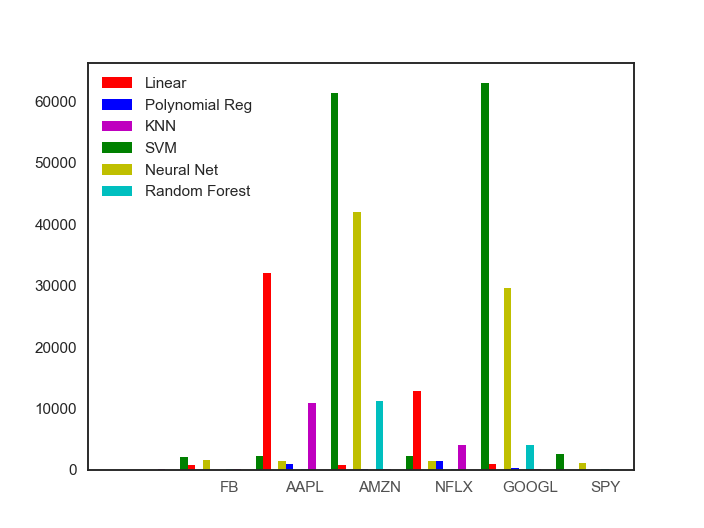

In [45]:
# automate this to the chart

colors = ['r', 'b', 'm', 'g', 'y', 'c']

plt.figure()
xl = list(range(0,len(results.columns)))

for i,model in enumerate(results.index.values):
    x = [x+(i*0.3) for x in xl]
    
    if model=="Random Forest":
        y = results.loc[model]
    else:
        y = results.loc[model]

    plt.bar(x, y, width = 0.1, color = colors[i], label=model)


plt.xticks(x, results.columns, alpha=0.8)
plt.legend()

In [ ]:
best_scores_dict

## Generating Buy/Sell Signals using Bollinger Bands and RandomForestClassification

In this section RandomForestClassification will be used to predict trading signals using Bollinger Bands. A Random forest model was chosen because they have been proven to perform well in research. The objective here is to demonstrate how classification can be used to generate trading signals rather than going through a full model selection process which was already demonstrated with regression.

### Plotting Bollinger Bands for Generating Buy/Sell Signals. 

#### Bollinger Bands

Bollinger Bands were developed by John Bollinger for technical analysis in the 1980's. Bollinger Bands can be created by taking a simple moving average or a rolling mean across a window of time. Then the upper and lower bands are plotted 2 standard deviations away from the rolling mean. To calculate the rolling mean using a 100 day window, sum the last 100 days of closing prices, then divide by 100 for each closing price. This means that the rolling mean starts on day 100 and no signals will occur before this point. 

When the stock price crosses the upper band this produces a sell signal as the stock price is expected to fall after this point. It is considered to be overbought and likely for a correction. The idea behind this is that the price will always return to the mean. Similarly, when the stock price crosses below the lower band the price is expected to rise and thus this produces a buy signal.

<IPython.core.display.Javascript object>


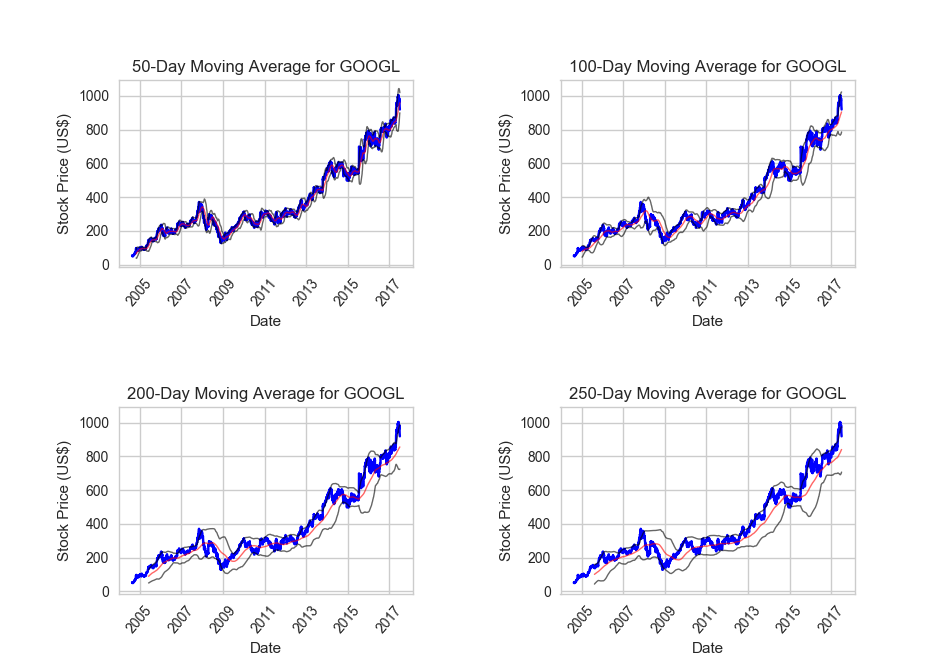

In [146]:
def plot_bollinger_bands(df, ticker):
    
    windows = [50, 100, 200, 250]
    
    fig = subplot_size_and_spacing(9.5, 6.67)
        
    subplots = []
    rows = math.ceil(len(windows)/2)

    for i,window in enumerate(windows):
        
        rolling_mean = df.rolling(window=window,center=False).mean()
        rolling_std = df.rolling(window=window,center=False).std()
              
        add_subplots(fig, rows, subplots, i)
        
        # X is the datetimeindex
        # specifying levels is only needed if the multiindex is added to the DataFrame as in the next step
        X = df.index.levels[0]  
        #X = df.index
        
        # y is the target adj close price
        y = df[ticker]
        alpha = 0.6

        plt.plot(X, y, color='b')
        # Bollinger Bands
        plt.plot(X, rolling_mean[ticker], linewidth=1, color='r', alpha=alpha)
        plt.plot(X, rolling_mean[ticker] + 2*rolling_std[ticker], linewidth=1, color='k', alpha=alpha)
        plt.plot(X, rolling_mean[ticker] - 2*rolling_std[ticker], linewidth=1, color='k', alpha=alpha)
        plt.xticks(rotation=50)
        plt.title(str(window) + "-Day Moving Average for " + ticker)
        chart_labels()

    #plt.title(str(window) + "-Day Moving Average for " + ticker)

plot_bollinger_bands(adj_close_df, 'GOOGL')    

### Creating the DataFrame

A new DataFrame is created because new features need to be added and many of the older features will be discarded. The new features include those for the moving averages as well as the model target - the trading signals of buy, sell and hold. Since these trading signals are the output of the model they do not need to be one-hot-encoded and can be merged into one column.

In [147]:
data_frames['GOOGL'].head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns,Daily Returns x Volume,Adj Close x Volume,Daily Returns x Adj Close,Daily Returns x Volume x Adj Close
Date,,,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,100.339996,50.220219,44659000,NaN,NaN,2.242785e+09,NaN,NaN
2004-08-20,50.555557,54.594593,50.300301,108.310005,54.209209,22834300,0.079430,1.813728e+06,1.237829e+09,4.305835,9.832074e+07
2004-08-23,55.430431,56.796795,54.579578,109.400002,54.754753,18256100,0.010064,1.837235e+05,9.996082e+08,0.551034,1.005974e+07
2004-08-24,55.675674,55.855854,51.836838,104.870003,52.487488,15247300,-0.041408,-6.313547e+05,8.002925e+08,-2.173383,-3.313822e+07
2004-08-25,52.532532,54.054054,51.991993,106.000008,53.053055,9188600,0.010775,9.900967e+04,4.874833e+08,0.571661,5.252766e+06


In [148]:
dfg = data_frames['GOOGL'].copy()

In [149]:
def create_clf_df(dfg, window):
    rolling_mean = dfg['Adj Close'].rolling(window=window,center=False).mean()
    rolling_std = dfg['Adj Close'].rolling(window=window,center=False).std()

    clf_df = pd.DataFrame({ 'Adj Close': dfg['Adj Close'],
                            'Adj Close Mean':  rolling_mean,
                            'Adj Close Upper Bound': rolling_std*2 + rolling_mean,
                            'Adj Close Lower Bound': rolling_mean - rolling_std*2,
                          })
    
    clf_df['Buy'] = clf_df['Adj Close'] < clf_df['Adj Close Lower Bound']
    clf_df['Sell'] = clf_df['Adj Close'] > clf_df['Adj Close Upper Bound'] 
    clf_df['Hold'] = ~ (clf_df['Sell'] | clf_df['Buy'])
    
    # clf_df[['Sell', 'Buy', 'Hold']] = clf_df[['Sell', 'Buy', 'Hold']].astype(int)
    # convert_date_to_time_elapsed(clf_df)
    
    dates = clf_df.index
    elapsed = dates - dates[0]
    clf_df['Days Elapsed'] = elapsed.days
    
    def get_signal():
        if clf_df['Adj Close'] > clf_df['Adj Close Upper Bound']:
            return "Buy"
        elif clf_df['Adj Close'] < clf_df['Adj Close Lower Bound']:
            return "Sell"
        else:
            return "Hold"
    
    # clf_df['Signal'] = ["Buy" if clf_df['Adj Close'] > clf_df['Adj Close Upper Bound']
            
    
    return clf_df

clf_df = create_clf_df(dfg, 100)

In [150]:
def get_signal(row):
    for col in ['Buy', 'Sell', 'Hold']:
        if row['Buy'] == True:
            return 0
        elif row['Sell'] == True:
            return 1
        elif row['Hold'] == True:
            return 2
        
        
clf_df['Signals'] = clf_df.apply(get_signal, axis=1)

In [168]:
clf_df.loc['2010-06-29': '2010-07-14']

,Adj Close,Adj Close Lower Bound,Adj Close Mean,Adj Close Upper Bound,Buy,Sell,Hold,Days Elapsed,Signals
Date,,,,,,,,,
2010-06-29,227.357361,229.554992,264.230830,298.906668,True,False,False,2140,0
2010-06-30,222.697693,228.144214,263.798698,299.453182,True,False,False,2141,0
2010-07-01,219.964966,226.619121,263.328327,300.037534,True,False,False,2142,0
2010-07-02,218.493500,225.056711,262.828377,300.600044,True,False,False,2143,0
2010-07-06,218.253250,223.540100,262.335985,301.131870,True,False,False,2147,0
2010-07-07,225.325333,222.430586,261.904554,301.378521,False,False,True,2148,2
2010-07-08,228.508514,221.500321,261.521371,301.542420,False,False,True,2149,2
2010-07-09,233.978973,220.800829,261.151951,301.503073,False,False,True,2150,2
2010-07-12,238.153152,220.263156,260.839739,301.416322,False,False,True,2153,2


In [163]:
clf_df.dropna().tail(20);

**Removing all the unnecessary columns**

In [153]:
clf_df = clf_df.dropna()
y = clf_df['Signals']
X = clf_df[['Days Elapsed', 'Adj Close', 'Adj Close Lower Bound', 'Adj Close Mean', 'Adj Close Upper Bound']]

In [154]:
clf_df['Signals'].value_counts()

2    2669
1     380
0      93
Name: Signals, dtype: int64

### Scatter Matrix: Exploring the Relationship between all the features

This scatter matrix exhibits some interesting differences from the prior ones used for regression. This is because of the presence of boolean values not present in the previous matricies. These relationships are all either horizontal or veritcal lines. The correlations between the upper and lower bounds, and the moving average and the adjusted close are almost exactly 1. But in this case they must stay because they are necessary to train the model. 

<IPython.core.display.Javascript object>


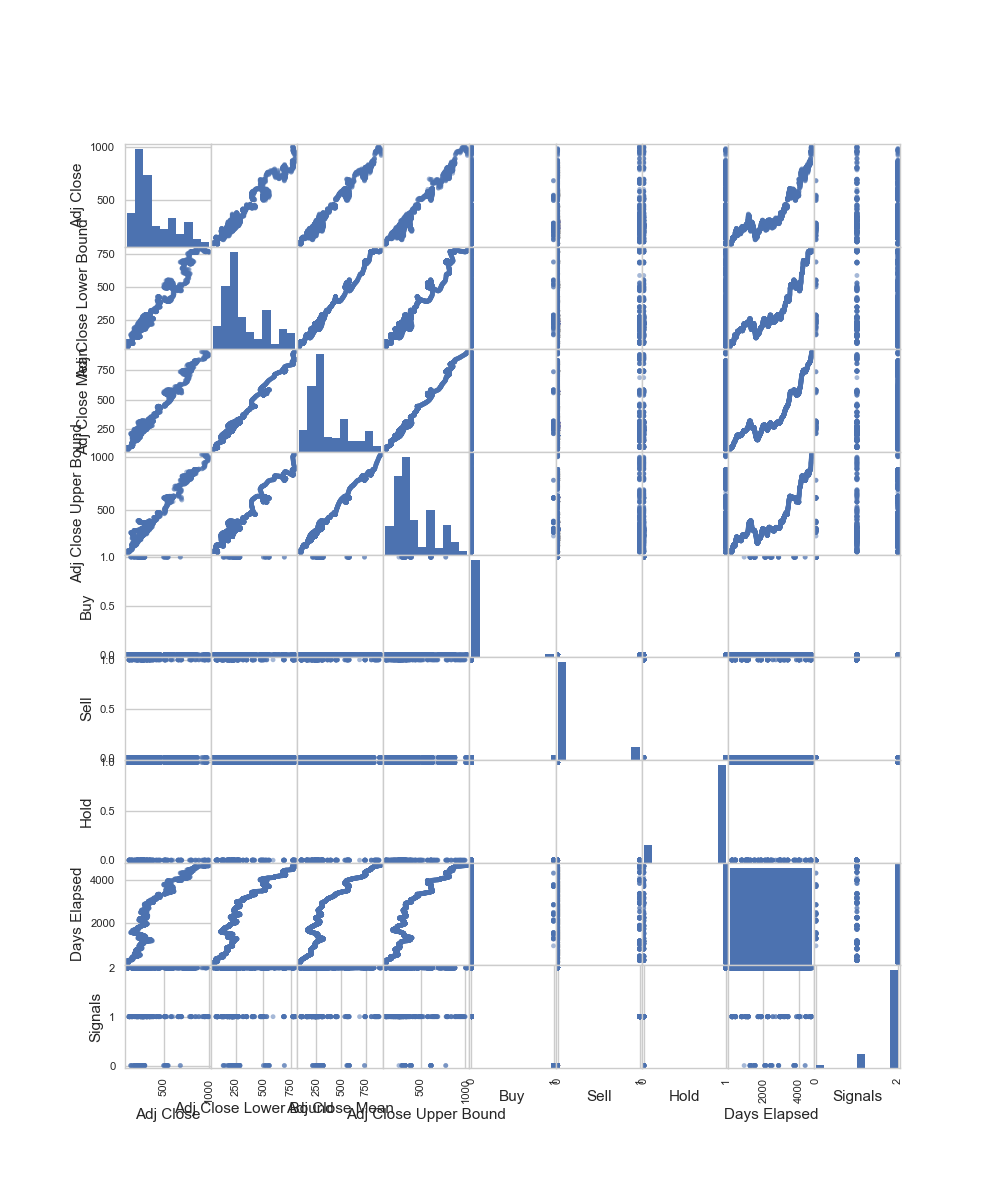

In [156]:
from pandas.plotting import scatter_matrix
attributes = clf_df.columns
scatter_matrix(clf_df[attributes], figsize=(10, 12));

### Training the RandomForestClassifier

In [ ]:
# This gives the count of each item in the output (buy, sell, hold)
# it can tell you if you have a balanced data set.
np.bincount(y)

In [158]:
## Training the RandomForestClassifier using grid search cv
# This is running a bit slow

def random_forest_clf_randomgridsearchcv(df):
    from sklearn.grid_search import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix

    rfr = RandomForestClassifier(n_estimators=100, max_depth=30, bootstrap=True)
    
    param_dist = dict(n_estimators=list(range(1,30)), max_depth=list(range(1,10)))

    y = clf_df['Signals']
    X = clf_df[['Days Elapsed', 'Adj Close', 'Adj Close Lower Bound', 'Adj Close Mean', 'Adj Close Upper Bound']]
    
    rand = RandomizedSearchCV(rfr, param_dist, cv=10, n_iter=20, random_state=0)
    rand.fit(X, y)
    rand.grid_scores_
    
    #print(rand.grid_scores_)
    print("-----------------")

    print(rand.best_score_)
    print(rand.best_params_)
    print(rand.best_estimator_)  
    
    # best_scores_dict[ticker]['Random Forest'] = rand.best_score_

In [159]:
# this is a little slow
%time
random_forest_clf_randomgridsearchcv(clf_df)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs
-----------------
0.8112667091024824
{'n_estimators': 9, 'max_depth': 1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


# Conclusion

In this study the Python ecosystem for data science (Python, Pandas, NumPy, Matplotlib, and Scikit-Learn) was explored. This was done specifically for use in stock price prediction (Regression) and generating buy and sell signals (Classification). Various models were considered and the performance of the **Polynomial Regression model** turned out to be the best overall in this case. This was not expected as it was thought that the Random Forests and Neural Networks would perform better considering their performance in research.

**Future Work**<br/>
There are improvements that can be made to these experiments. Additional features can be added to the models. This often improves performance once the right tuning is done. Running the models on a more powerful cloud server will likely improve the disappointing performance for SVMs and Neural Nets. These shall be left for future exploration as this study was already quite exhaustive.

# References

1. Balch, Tucker, et al. Machine Learning for Trading. Udacity, [https://www.udacity.com/course/machine-learning-for-trading--ud501](https://www.udacity.com/course/machine-learning-for-trading--ud501).

1. Géron, Aurélien. "Hands-on Machine Learning with Scikit-Learn and Tensorflow." (2017).

1. Hunter, John D. "Matplotlib: A 2D graphics environment." Computing In Science & Engineering 9.3 (2007): 90-95.

1. McKinney, Wes. "Data structures for statistical computing in python." Proceedings of the 9th Python in Science Conference. Vol. 445. Austin, TX: SciPy, 2010.

1. Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." Journal of Machine Learning Research 12.Oct (2011): 2825-2830.